# Statistics of Master-HEAD

In [1]:
import json, re, pprint, os
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('pgf') # this makes exports more beautiful, but disables plots in this notebook

FOLDER='stable-spark18pro-pluslatest-rru1204'

pltsettings = {
    "figure.figsize" : (5.0, 4.0),
    "pgf.texsystem" : "pdflatex",
    "font.family": "sans",
    "font.serif": [],                   # use latex default serif font
    #"font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
}
matplotlib.rcParams.update(pltsettings)

import matplotlib.pyplot as plt
#import seaborn as sns # makes exports ugly

In [2]:
def read_json(fname):
    """
    reads JSOn and returns (totals, units), tuple of dicts
    """
    units=None
    totals=None
    with open(fname,'r') as f:
        endofunits = False
        for line in f:
            match = re.search(r'^TOTALS', line)        
            if match:                
                endofunits = True
            if not endofunits:
                try:
                    if not units:
                        units = json.loads(line)
                    else:
                        print "error: units appearing multiple times"
                except:
                    pass
            else:
                try:
                    if not totals:
                        totals = json.loads(line)
                    else:
                        print "error: totals appearing multiple times"
                except:
                    pass
    # unpack units (list of dicts) => dict
    tmp=units
    units={}
    for u in tmp:
        name=u.keys()[0]
        stats=u[name]        
        units[name]=stats       
    return (totals, units)
            
#######
(totals, units) = read_json(FOLDER + os.sep + 'unitstats-json-detail.log')
print "TOTALS: "
pprint.pprint(totals)
#print "UNITS: "
#u0 = "mission" #u0 = units.keys()[0]
#print u0 + ": "+ str(units[u0])


TOTALS: 
{u'ent_cov': 57.970112079701124,
 u'ents': 1606,
 u'flows': 1795,
 u'flows_proven': 1713,
 u'flows_success': 95.4317548746518,
 u'flows_suppressed': 29,
 u'props': 2184,
 u'proven': 1877,
 u'rules': {u'ALIASING': {u'cnt': 16, u'proven': 16},
            u'UNINITIALIZED': {u'cnt': 1779, u'proven': 1697},
            u'VC_ASSERT': {u'cnt': 21, u'proven': 13},
            u'VC_CEILING_PRIORITY_PROTOCOL': {u'cnt': 2, u'proven': 2},
            u'VC_CONTRACT_CASE': {u'cnt': 4, u'proven': 4},
            u'VC_DISCRIMINANT_CHECK': {u'cnt': 65, u'proven': 64},
            u'VC_DISJOINT_CONTRACT_CASES': {u'cnt': 1, u'proven': 1},
            u'VC_DIVISION_CHECK': {u'cnt': 75, u'proven': 70},
            u'VC_FP_OVERFLOW_CHECK': {u'cnt': 465, u'proven': 259},
            u'VC_INDEX_CHECK': {u'cnt': 42, u'proven': 42},
            u'VC_LENGTH_CHECK': {u'cnt': 178, u'proven': 174},
            u'VC_OVERFLOW_CHECK': {u'cnt': 95, u'proven': 77},
            u'VC_POSTCONDITION': {u'cnt': 67,

## Property Occurence

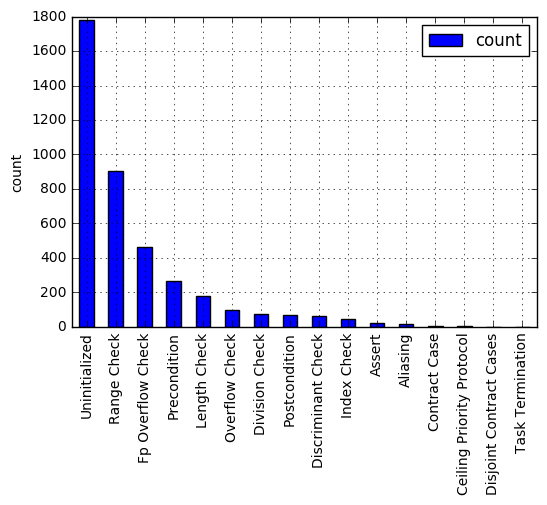

In [3]:
# plot success per VC type; rows are VCs, columns are "success", "fail"
def pretty_vcname(VCname):
    parts = VCname.split("_");
    if parts[0] == "VC":
        parts = parts[1:]    
    return " ".join(parts).title()

counters={pretty_vcname(k) : v['cnt'] for k,v in totals["rules"].iteritems()}
df_cnt = pd.DataFrame(counters,index=['count']).T
#print df2.head()
# sort by occurence
df_cnt.sort_values(by='count', ascending=False, inplace=True)
ax=df_cnt.plot.bar();
ax.set_ylabel('count')
ax.grid()
plt.savefig(FOLDER + os.sep + 'props.pdf', bbox_inches='tight')
plt.show()

## Success Ratio of Properties (Normalized)

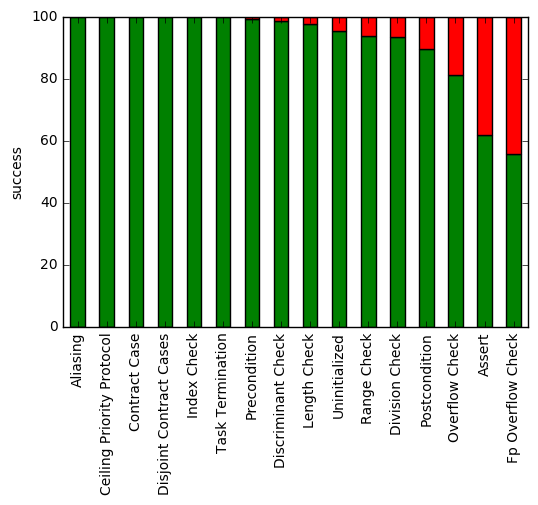

In [4]:
# plot success per VC type; rows are VCs, columns are "success", "fail"
VCs={pretty_vcname(k) : {'proven' : 100.0*v['proven'] / v['cnt'], 'unsuccessful': 100.0*(v['cnt']-v['proven'])/v['cnt'] } for k,v in totals["rules"].iteritems()}
df2 = pd.DataFrame(VCs).T
#print df2.head()
df2.sort_values(by='proven', inplace=True, ascending=False)
ax=df2.plot.bar(stacked=True,color=['green','red'],legend=False);
ax.set_ylabel('success')

plt.savefig(FOLDER + os.sep + 'vc_success.pdf', bbox_inches='tight')
plt.show()

## Success Ratio by unit

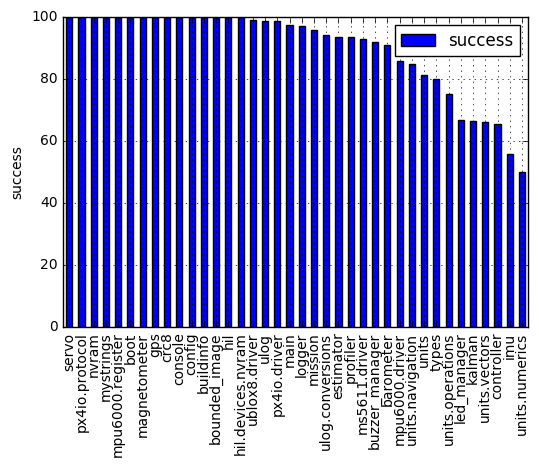

In [5]:
unit_success = {k : {'success': v['success'], 'cnt' : v['props']} for k,v in units.iteritems()}
df_usucc = pd.DataFrame(unit_success).T
df_usucc.sort_values(by='success', inplace=True, ascending=False)
exclude_columns=['cnt']
ax=df_usucc.ix[df_usucc.cnt>0,df_usucc.columns.difference(exclude_columns)].plot.bar();
ax.set_ylabel('success')
ax.grid()
plt.show()

                 cnt  proven     success  unsuccessful
barometer       11.0    10.0   90.909091           1.0
boot             2.0     2.0  100.000000           0.0
bounded_image   35.0    35.0  100.000000           0.0
buildinfo       16.0    16.0  100.000000           0.0
buzzer_manager  12.0    11.0   91.666667           1.0


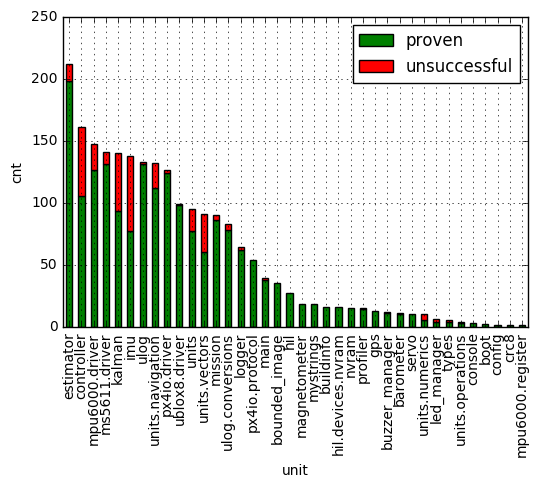

In [6]:
unit_cnt = {k : { 'proven' : v['proven'], 'unsuccessful' : v['props'] - v['proven'], 'cnt':v['props'], 'success' : 100.0 if v['props']==0 else (100.0*v['proven'])/v['props']} for k,v in units.iteritems() if v['props']>0}
df_ucnt = pd.DataFrame(unit_cnt).T
# filter those where cnt=0


print df_ucnt.head()
df_ucnt.sort_values(by=['cnt','proven'], inplace=True, ascending=False)
exclude_columns=['cnt','success']

ax=df_ucnt.ix[df_ucnt.cnt>0,df_ucnt.columns.difference(exclude_columns)].plot.bar(stacked=True,color=['green','red']);              
ax.set_ylabel('cnt')
ax.set_xlabel('unit')
ax.grid()
plt.savefig(FOLDER + os.sep + 'units_props.pdf', bbox_inches='tight')
plt.show()

## Failure Ratio does not depend on #props:

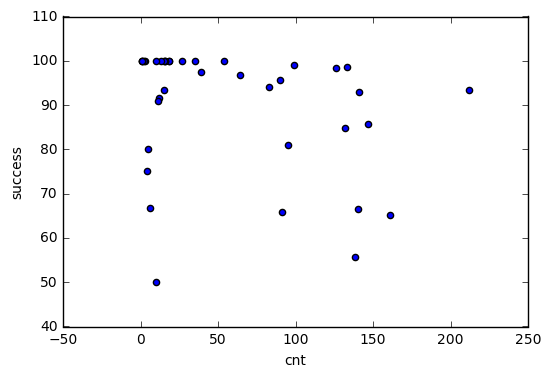

In [7]:
df_ucnt.plot.scatter(x='cnt', y='success');
plt.show()

## Coverage per Unit
Show that HAL/BSP are just spec and app is full SPARK
TODO: Units which have SPARK-Mode off in spec -> they do not appear here, which is unfair

### SPARK_Mode
Tri-state:
 * On (Must be in SPARK)
 * Off (forbid GNATprove to analyze this)
 * Auto (implicit: take whatever is compliant to SPARK as SPARK; ignore rest)

### What does "spec" mean?
Does it mean that there is a contract, or only that the spec is in a scope with SPARK mode on?

### Mixed Unit
Does it count non-SPARK subs in the body?

### Non-SPARK Unit
Does GNATprove count the specs even? 
 * yes, but only SPARK-compliant specs. E.g., it skips functions with side effects   
 * FAT_Filesystem.Directories: lot of functions. Ents=0
 
We need to count entities ourselves, somehow.



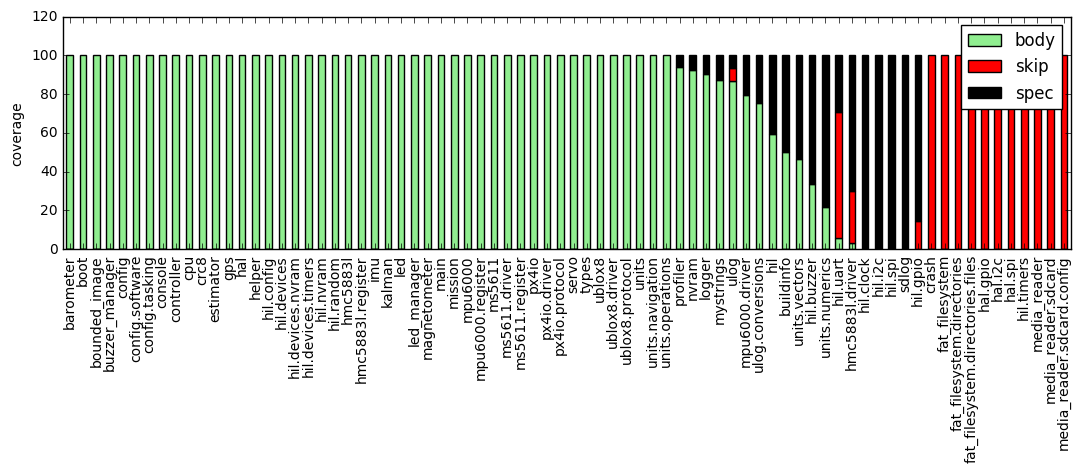

{u'body': 0, u'flows_proven': 0, u'success': 100.0, u'rules': {}, u'skip': 30, u'flows_success': 100.0, u'proven': 0, u'entities': [{u'name': u'Directories', u'type_orig': u'K', u'file': u'fat_filesystem-directories.ads', u'line': 8, u'type': u'package', u'col': 24}, {u'name': u'Open_Root_Directory', u'type_orig': u'V', u'file': u'fat_filesystem-directories.ads', u'line': 12, u'type': u'function', u'col': 13}, {u'name': u'Open', u'type_orig': u'V', u'file': u'fat_filesystem-directories.ads', u'line': 18, u'type': u'function', u'col': 13}, {u'name': u'Make_Directory', u'type_orig': u'V', u'file': u'fat_filesystem-directories.ads', u'line': 24, u'type': u'function', u'col': 13}, {u'name': u'Close', u'type_orig': u'U', u'file': u'fat_filesystem-directories.ads', u'line': 33, u'type': u'procedure', u'col': 14}, {u'name': u'Read', u'type_orig': u'V', u'file': u'fat_filesystem-directories.ads', u'line': 35, u'type': u'function', u'col': 13}, {u'name': u'Get_Name', u'type_orig': u'V', u'file'

In [8]:
filter=['stm32','cortex','generic']#,'hil.','driver','hal','register']
unit_cov = {u : {'body': v["coverage"], 'spec': 100.0*v['spec'] / v['ents'] if v['ents'] > 0 else 0, 'ents' : v['ents'], 'skip': 100.0*v['skip']/v['ents']} for u,v in units.iteritems() if (not any(f in u for f in filter) and v['ents']>0)}
df_ucov = pd.DataFrame(unit_cov).T
df_ucov.sort_values(by=['body','spec','skip'], inplace=True, ascending=False)
exclude_columns=['ents']

ax=df_ucov.ix[:,df_ucov.columns.difference(exclude_columns)].plot.bar(stacked=True,figsize=(13,3),color=["lightgreen", "red", "black"]);
ax.set_ylabel('coverage')
plt.savefig(FOLDER + os.sep + 'units_cov.pdf', bbox_inches='tight')
plt.show()
print units["fat_filesystem.directories"]


## Flows by unit

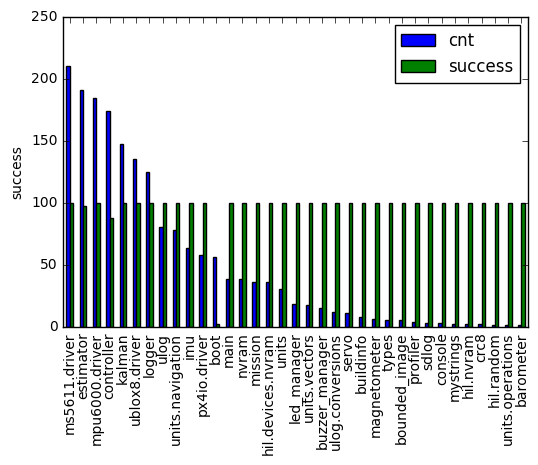

In [9]:
filter=['stm32','cortex','generic']
unit_flow = {u : {'cnt': v['flows'], 'success': v['flows_success'] } for u,v in units.iteritems() if (not any(f in u for f in filter) and v['flows']>0)}
df_flows = pd.DataFrame(unit_flow).T
df_flows.sort_values(by=['cnt'], inplace=True, ascending=False)
exclude_columns=[]
ax=df_flows.ix[:,df_flows.columns.difference(exclude_columns)].plot.bar();
ax.set_ylabel('success')
plt.show()

## by task? not yet possible

# specific check by package

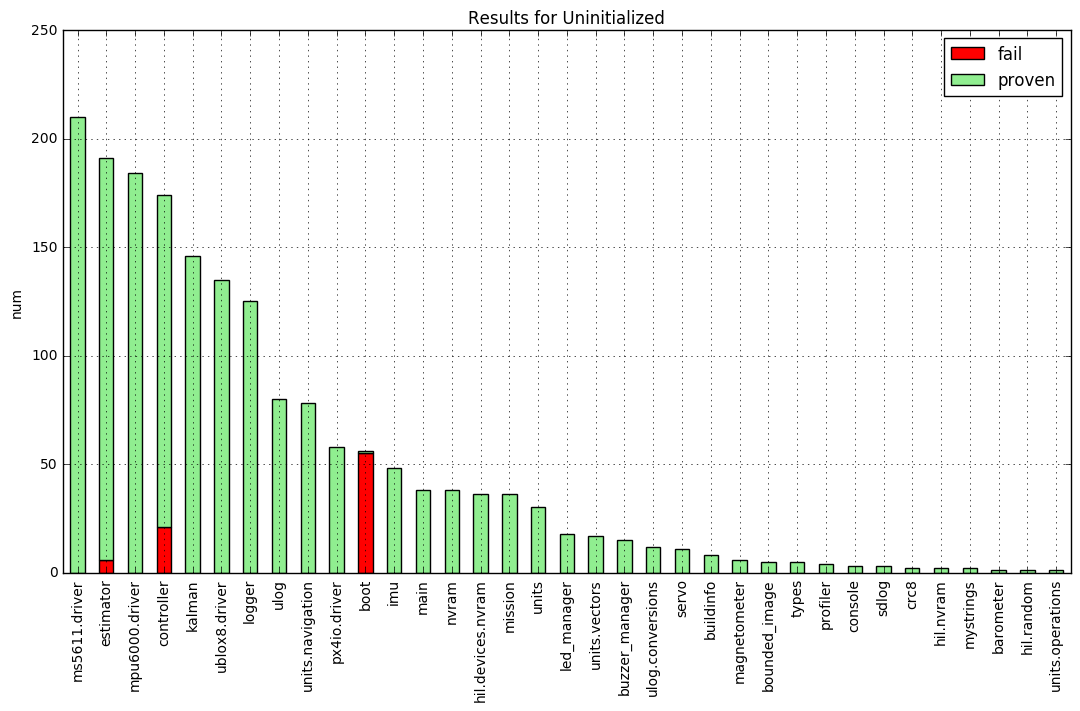

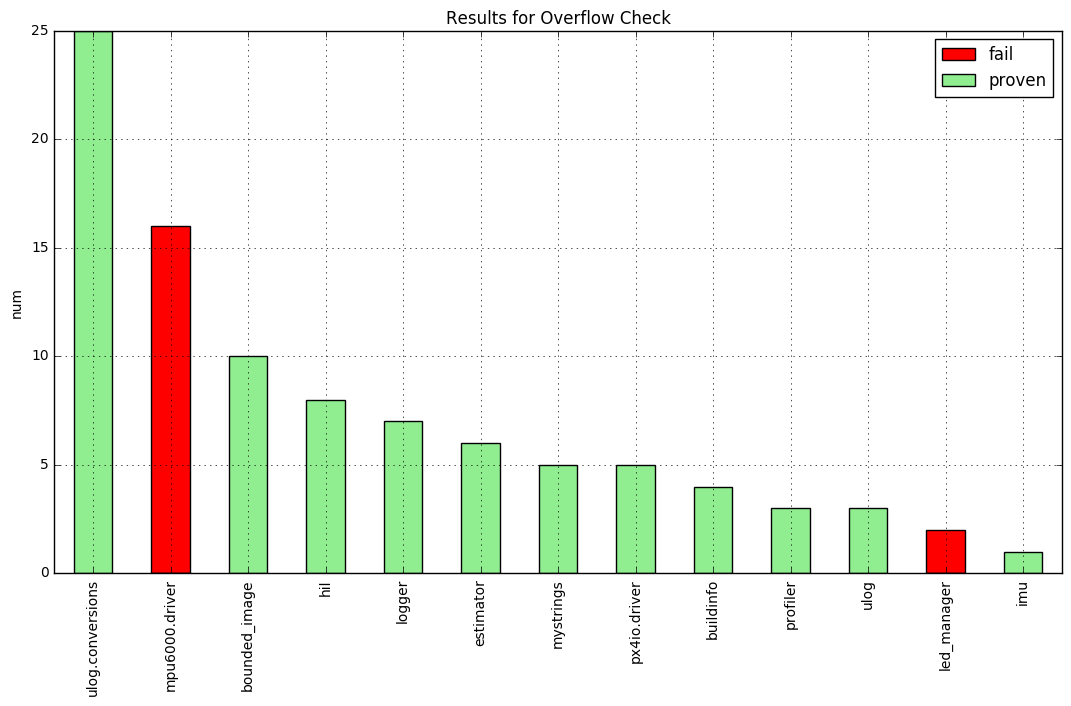

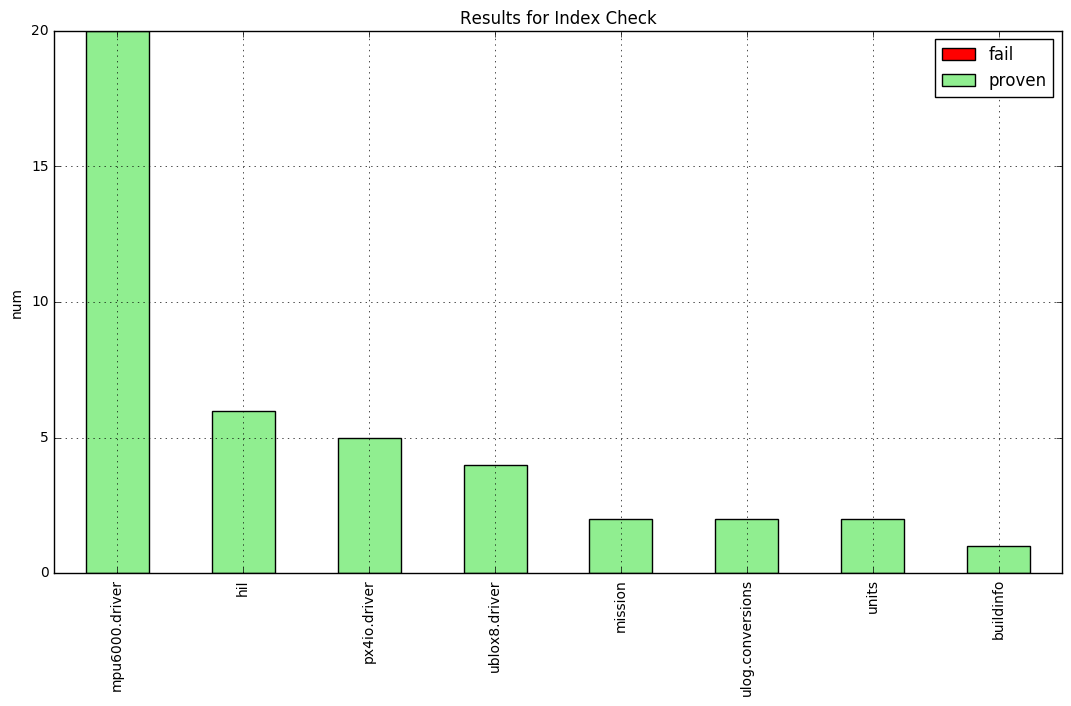

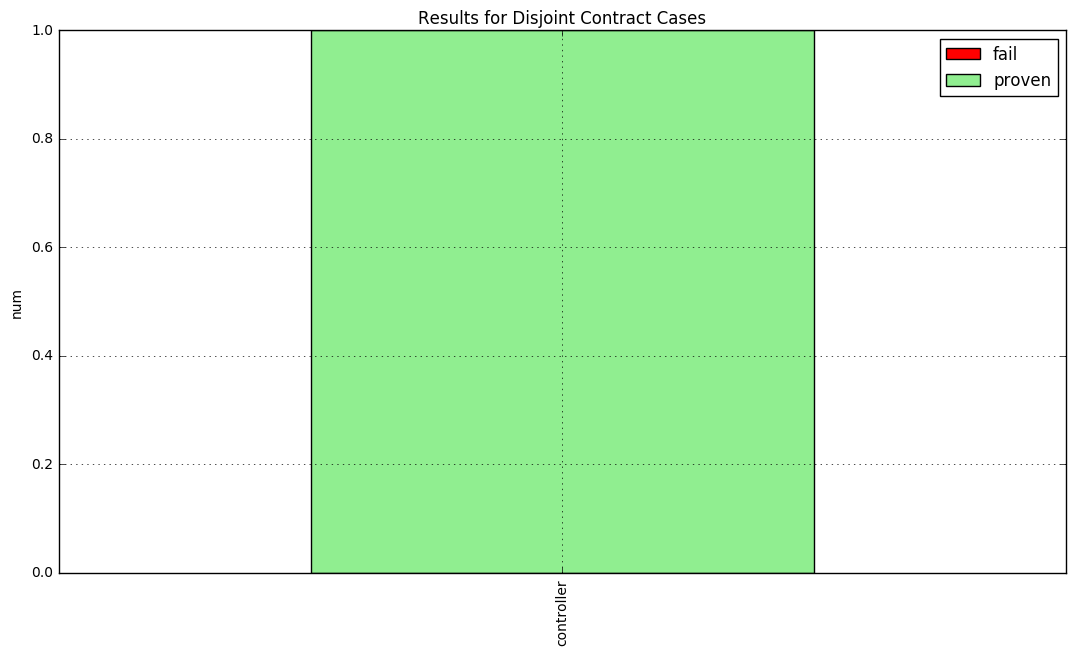

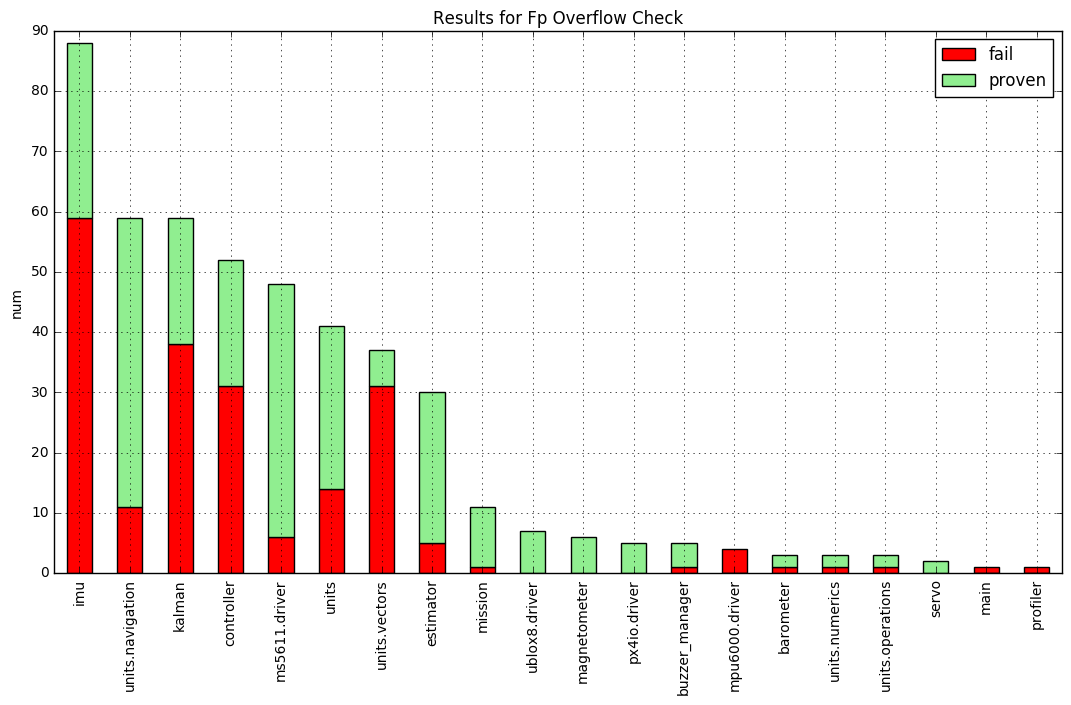

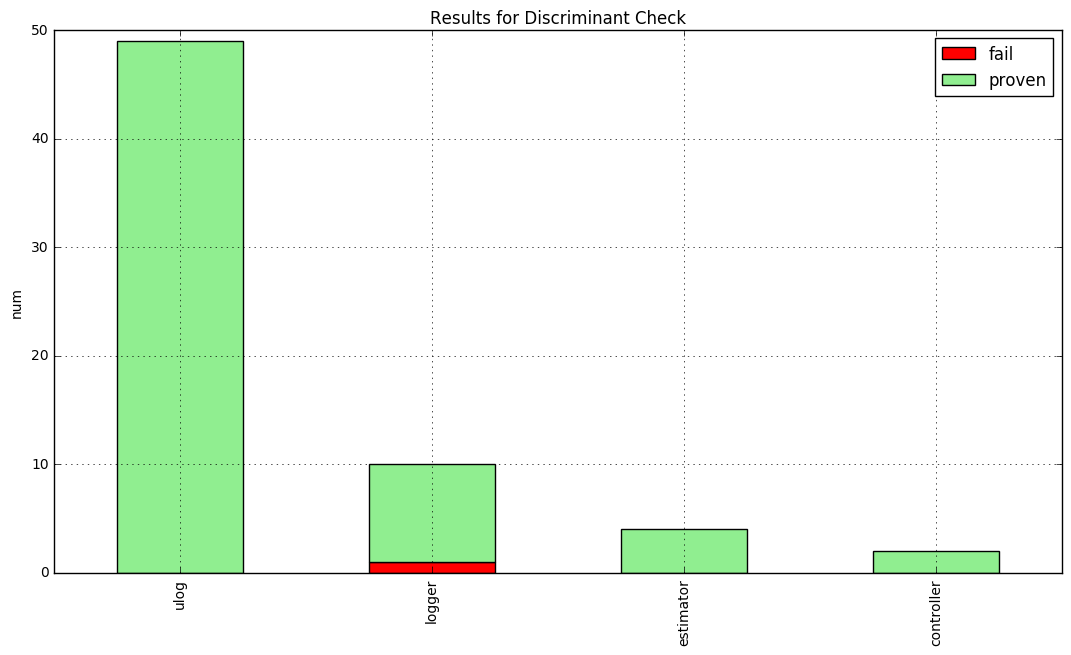

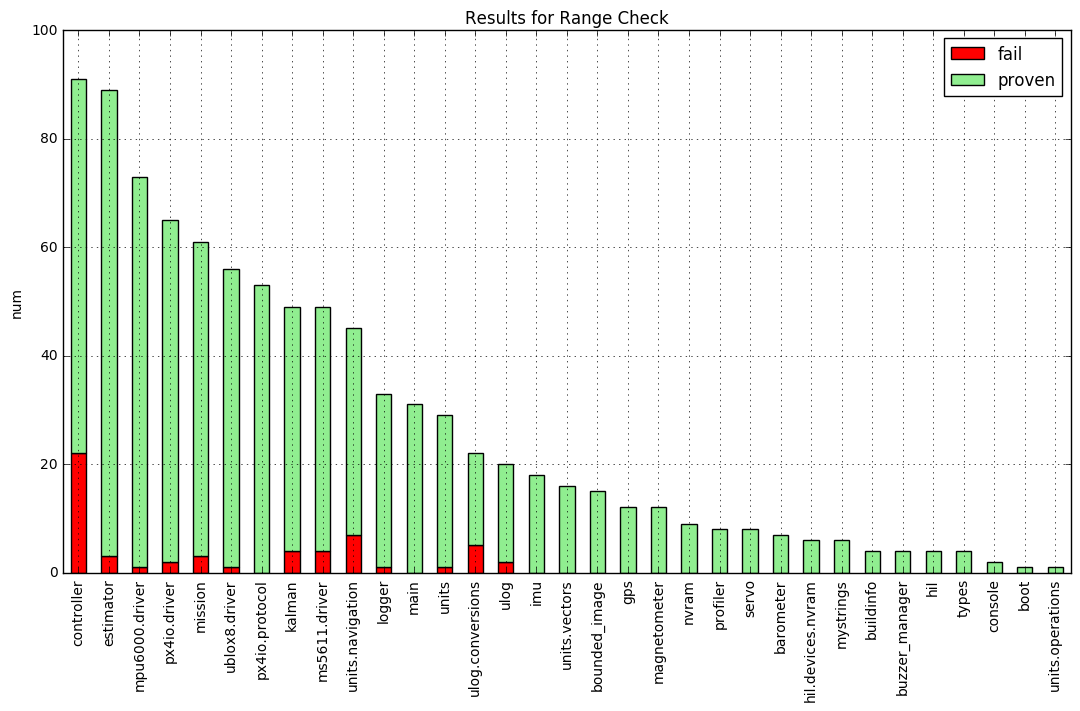

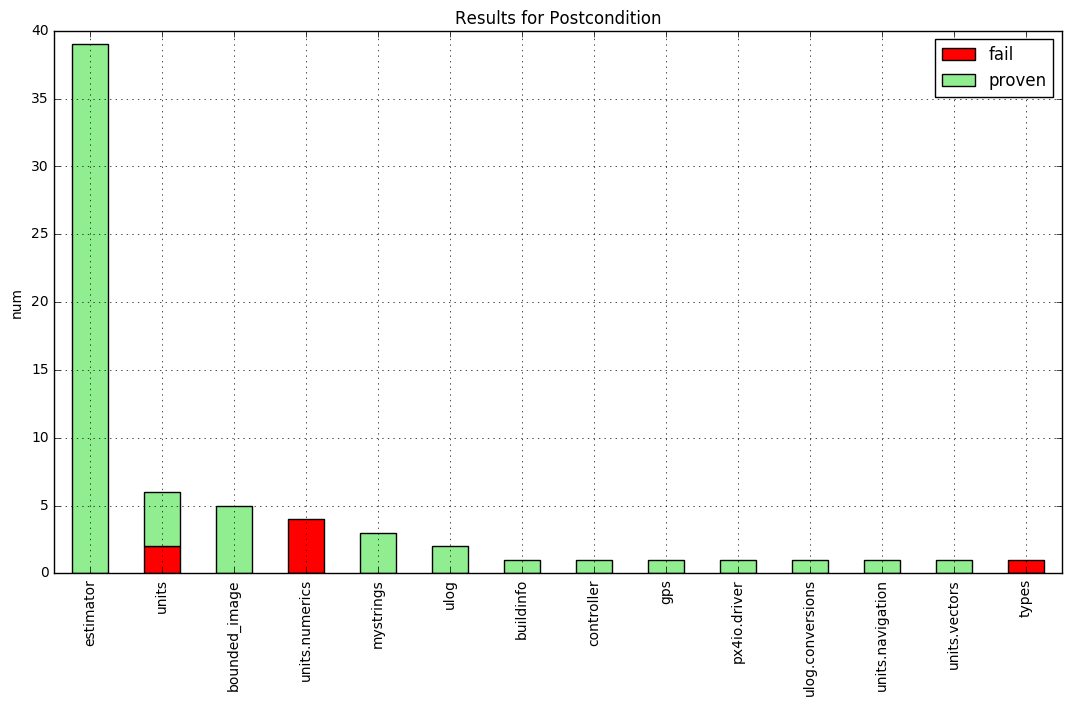

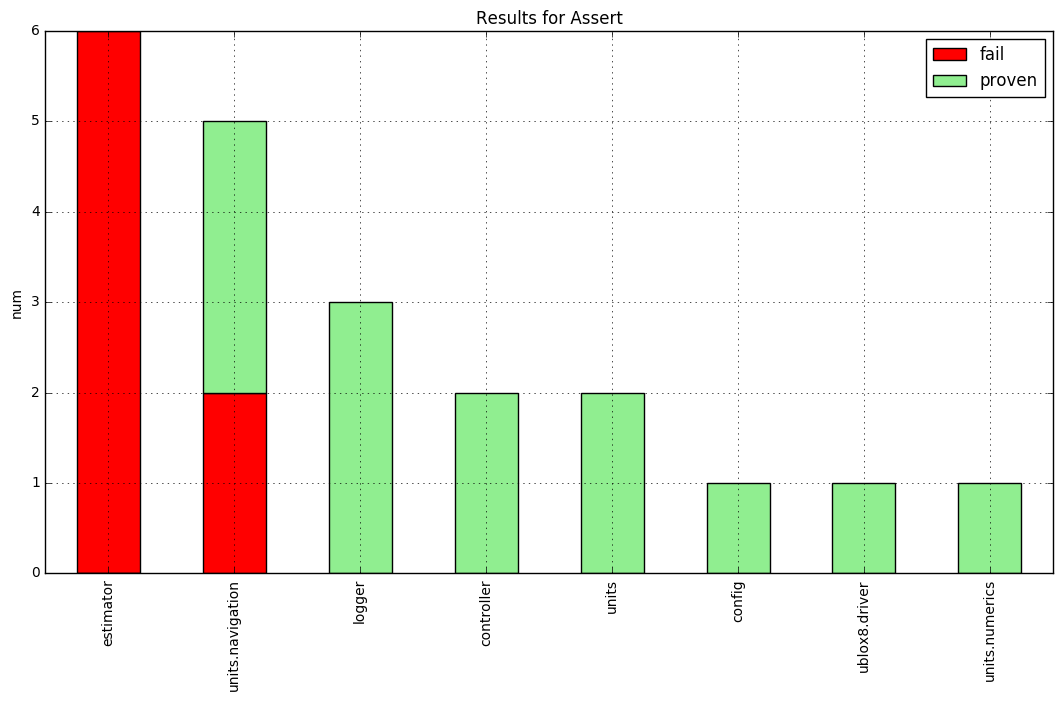

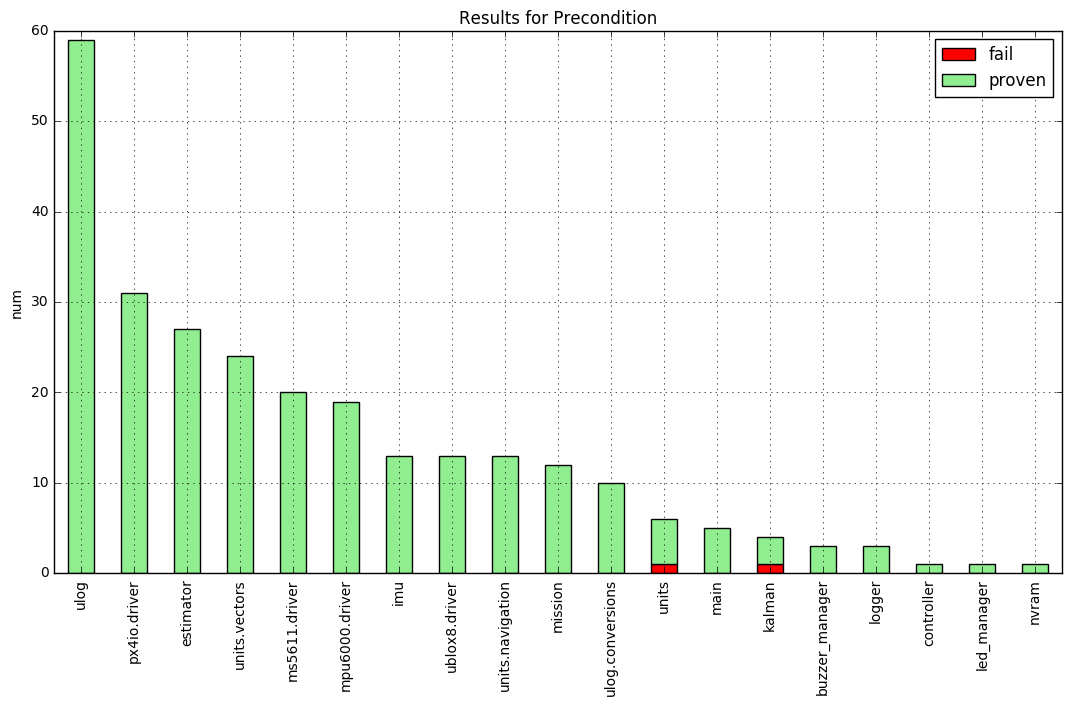

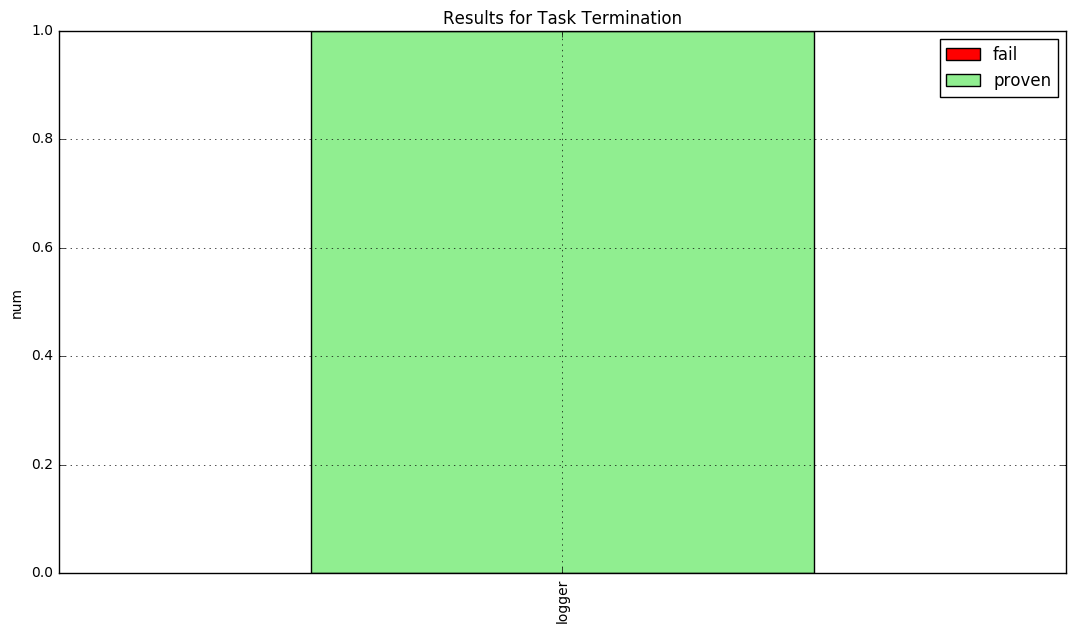

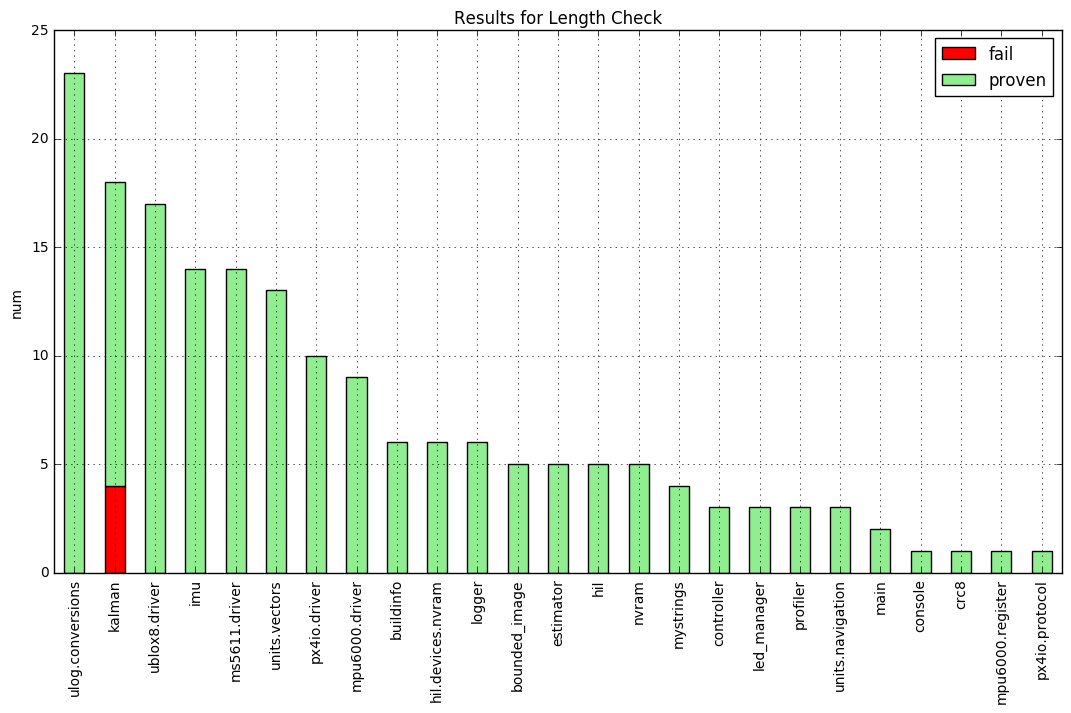

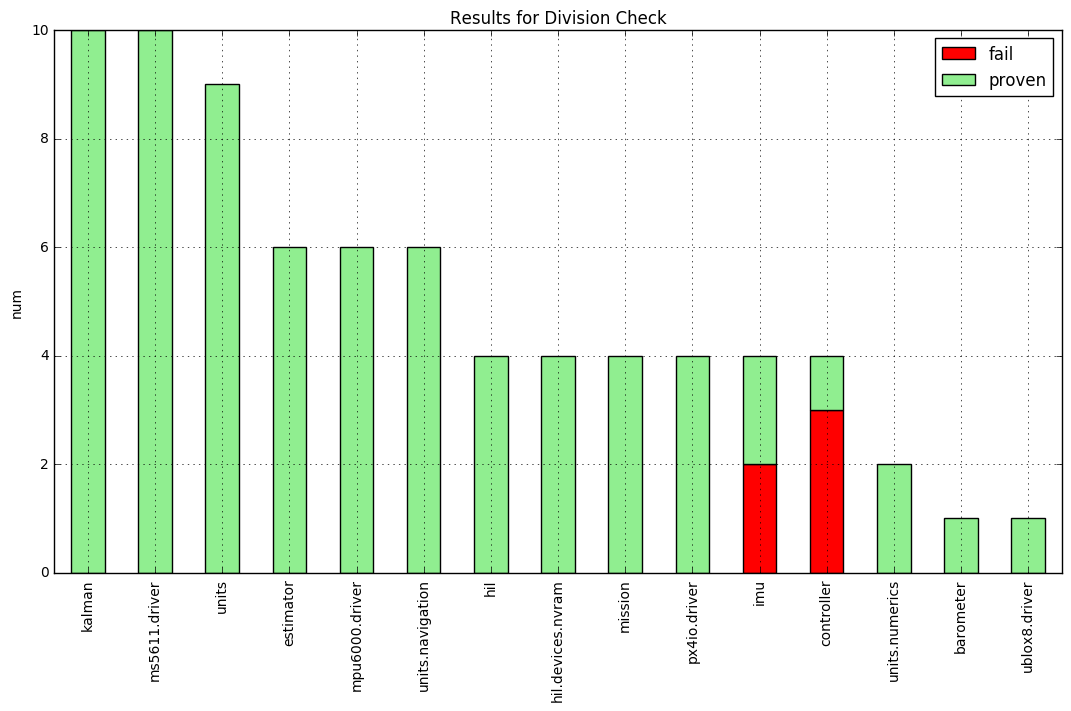

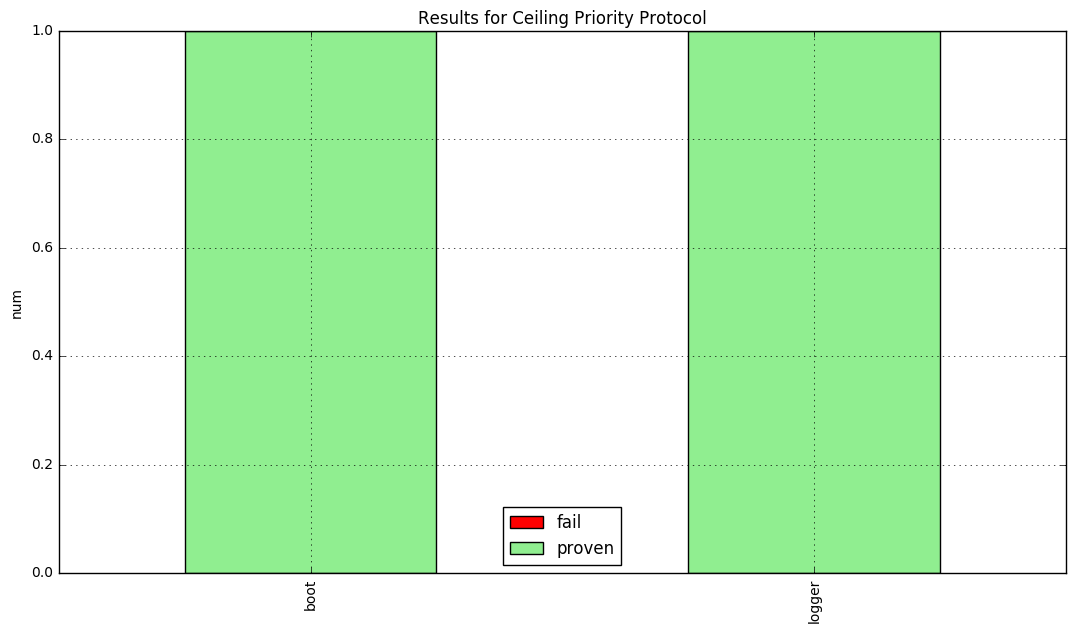

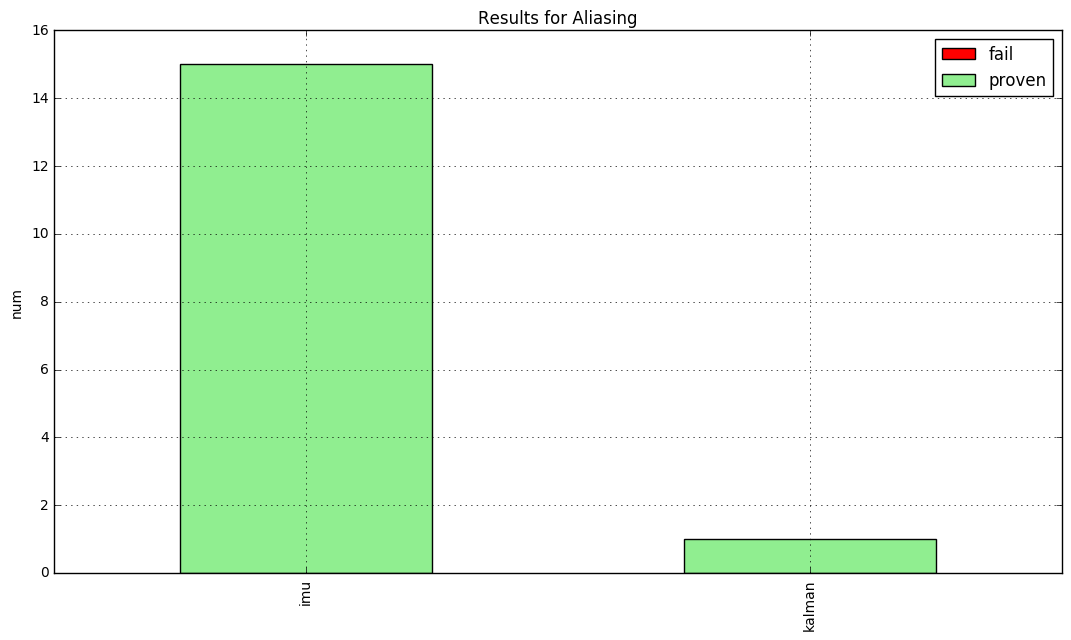

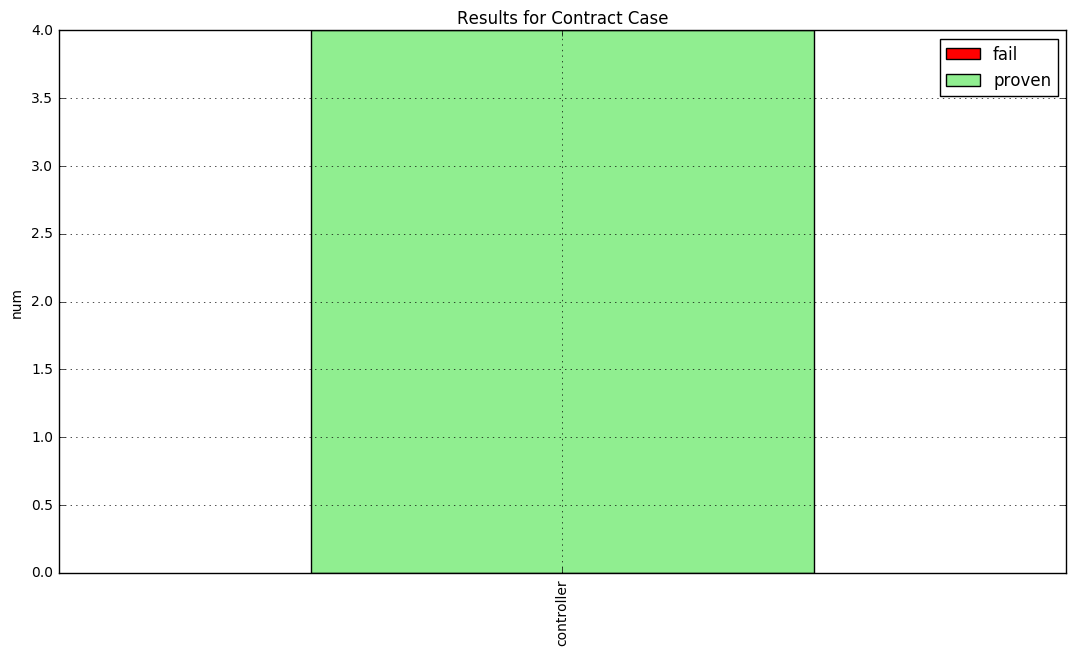

In [10]:
def plot_vc (vcname):
    """
    Plot success for a specific VC in all units
    """
    res = {}
    for u,v in units.iteritems():
        for r, rv in v['rules'].iteritems():
            if r == vcname and rv and 'cnt' in rv and rv['cnt'] > 0:
                res[u] = { 'cnt' : rv['cnt'], 'proven' : rv['proven'], 'fail' : rv['cnt'] - rv['proven'] }

    df_vc = pd.DataFrame(res).T
    df_vc.sort_values(by=['cnt','proven'], inplace=True, ascending=False)
    exclude_columns=['cnt']

    ax=df_vc.ix[:,df_vc.columns.difference(exclude_columns)].plot.bar(stacked=True,figsize=(13,7),color=["red", "lightgreen"]);
    ax.set_ylabel('num')
    ax.set_title('Results for ' + pretty_vcname(vcname))
    ax.grid()
    plt.savefig(FOLDER + os.sep + 'units' + vcname + '.pdf', bbox_inches='tight')
    plt.show()

for vc in totals["rules"].keys():
    plot_vc(vc)

# Analysis Time per Module and VC Type

################################
# TOTAL CPU TIME = 164.0 min
################################
Note: divide by number of cores to get approximate wall-clock time


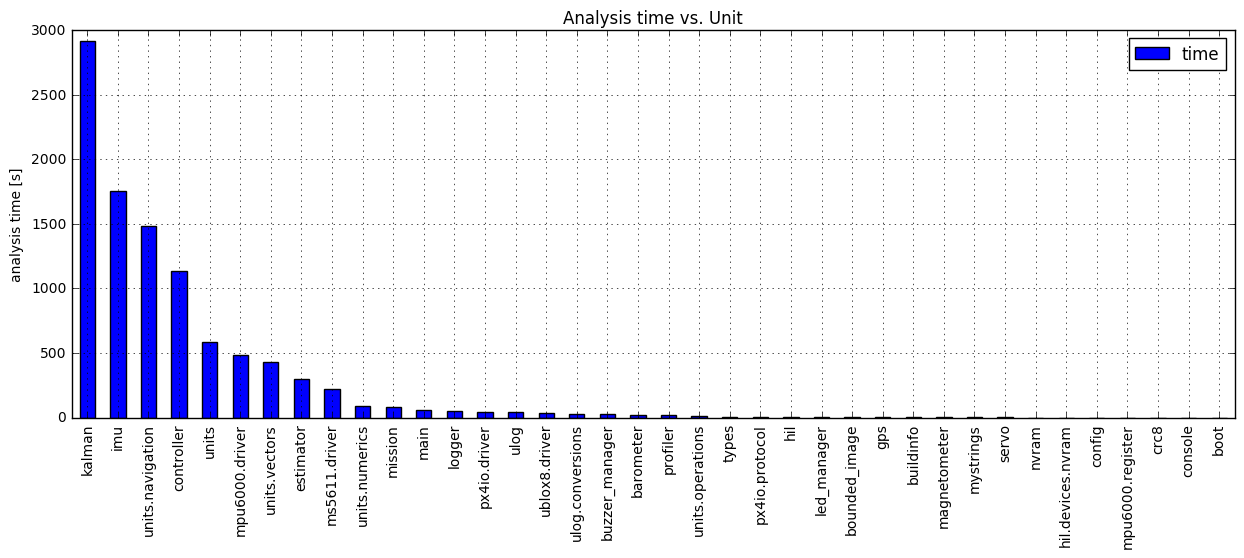

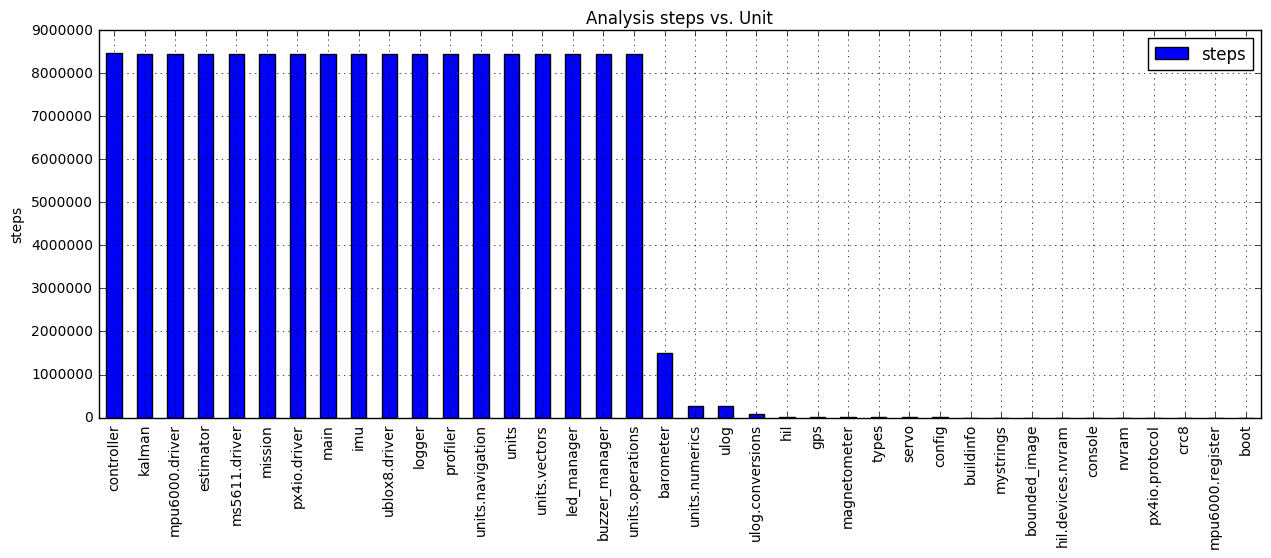

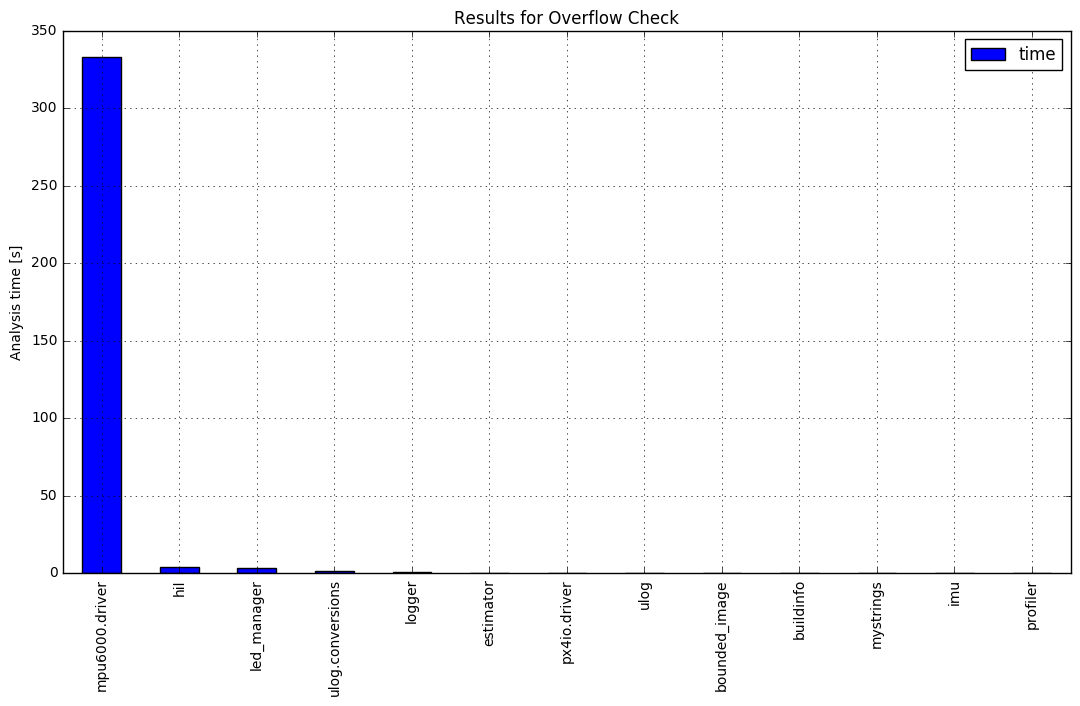

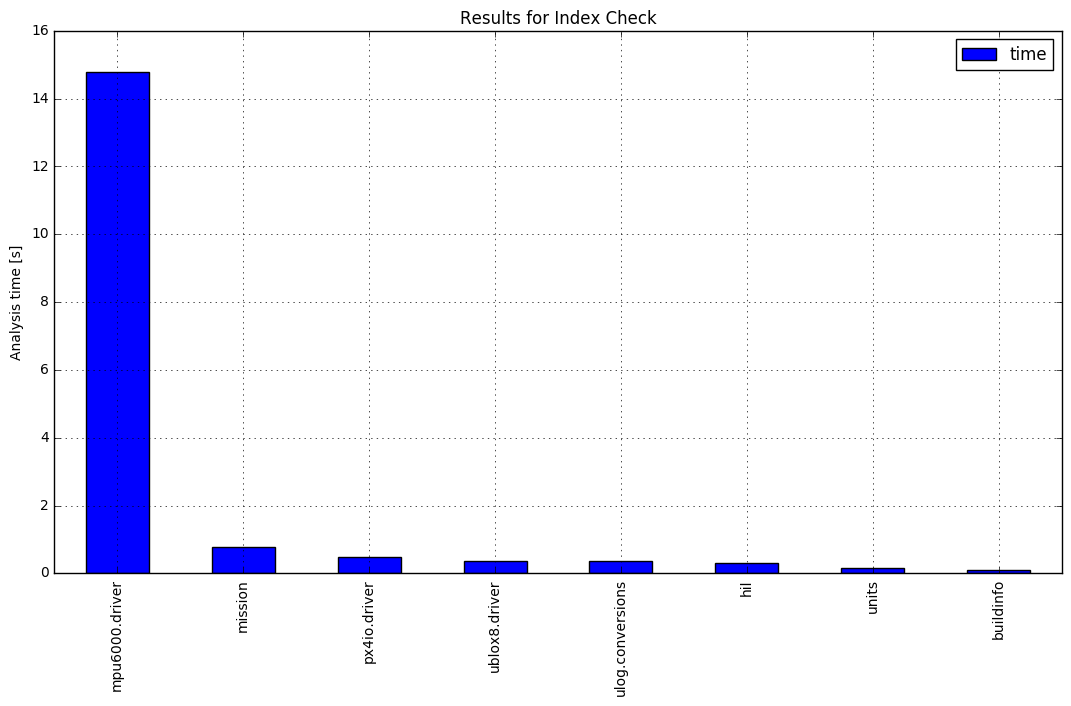

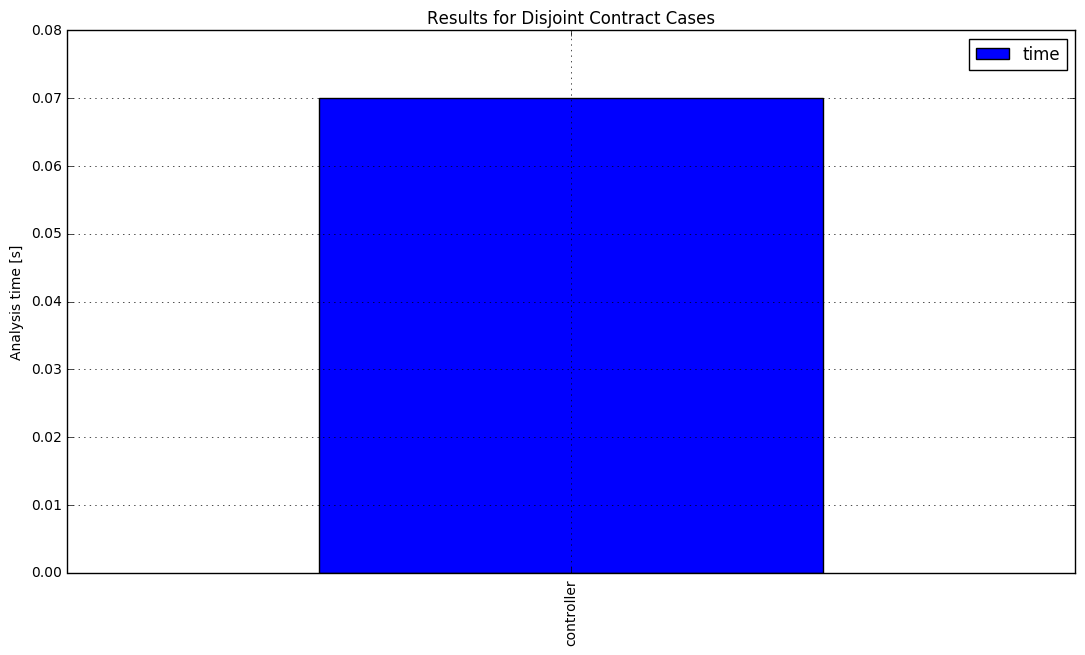

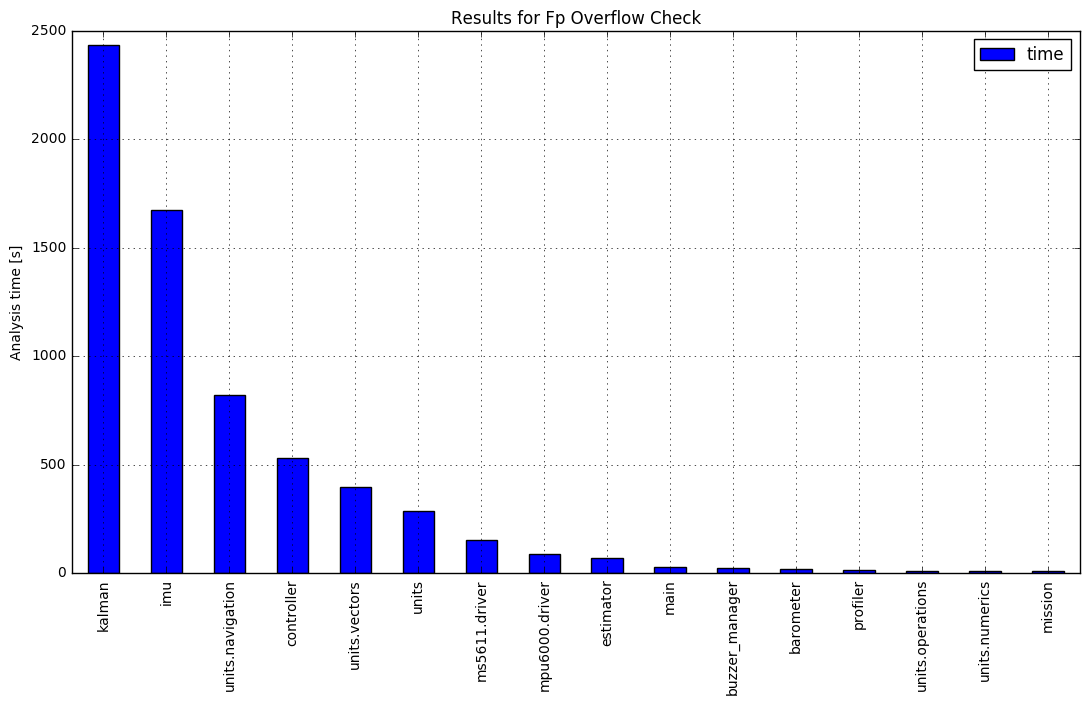

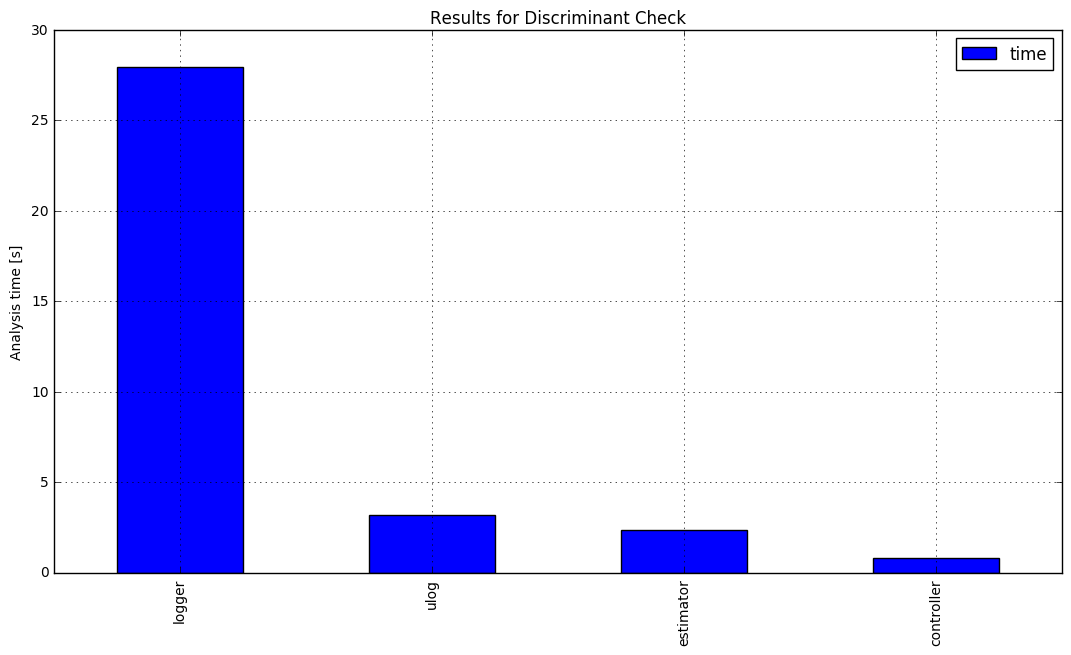

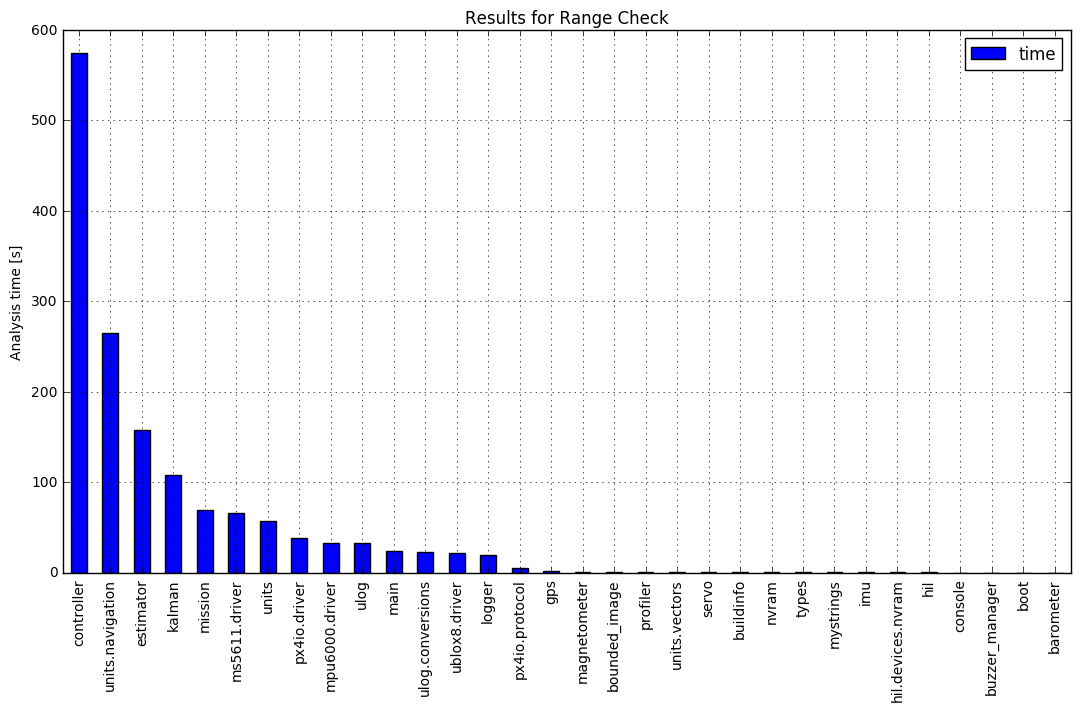

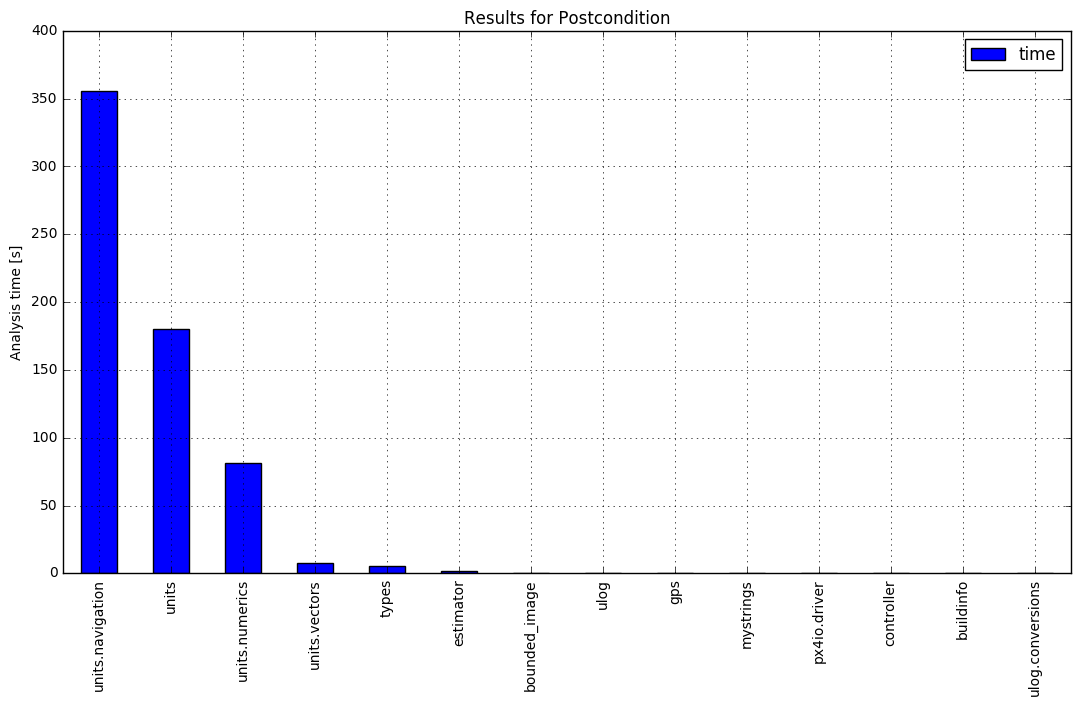

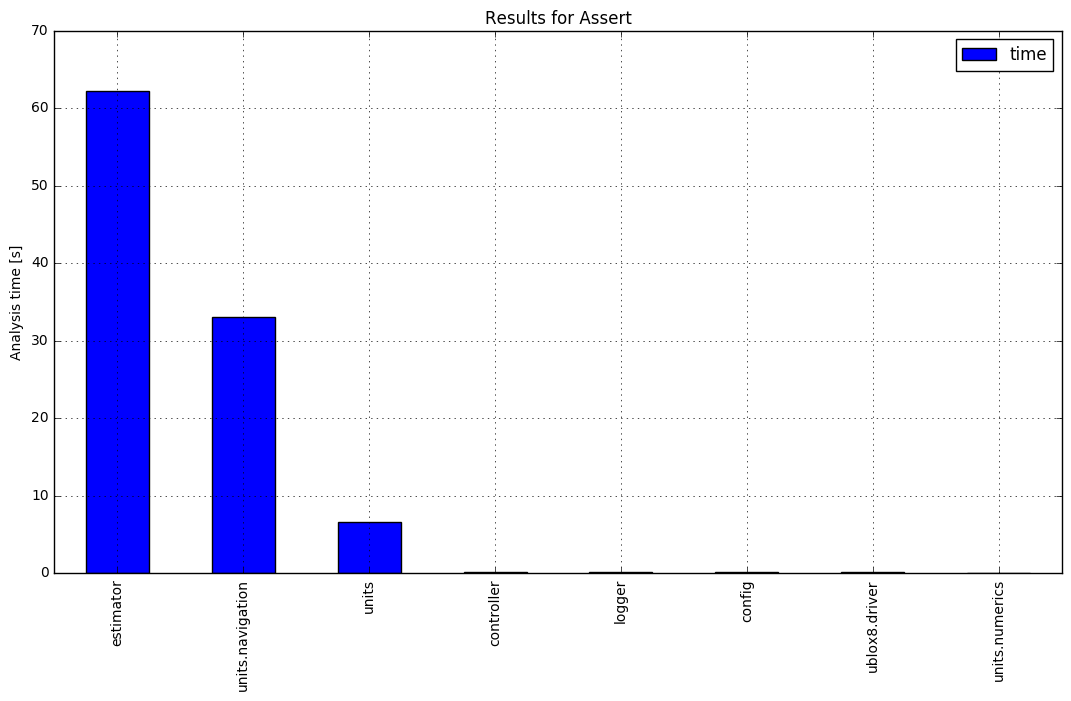

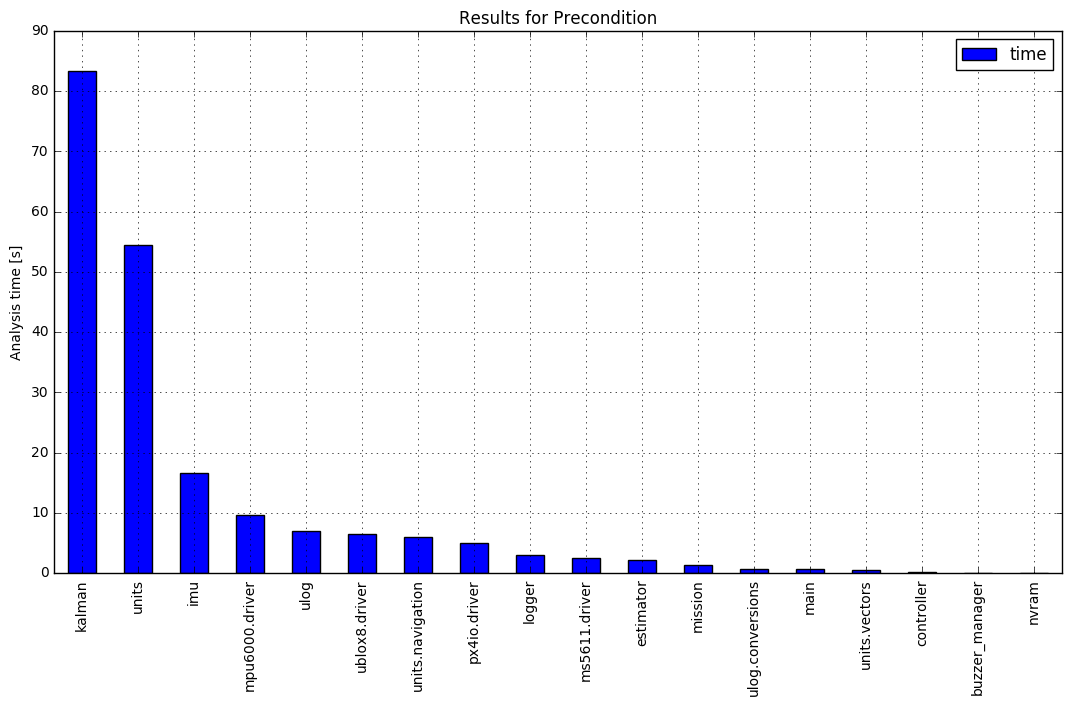

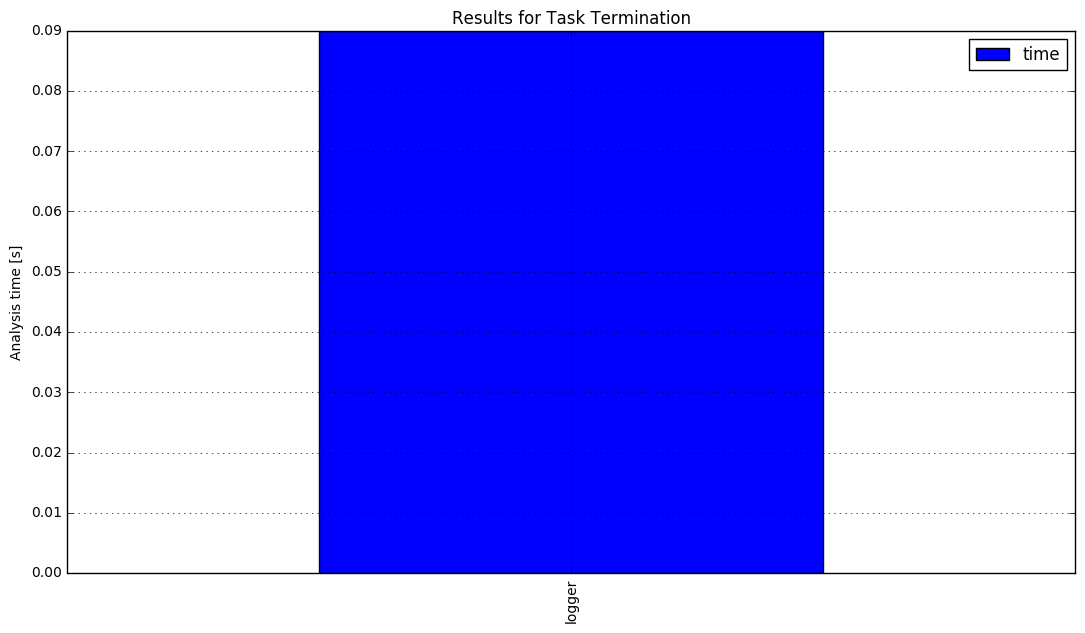

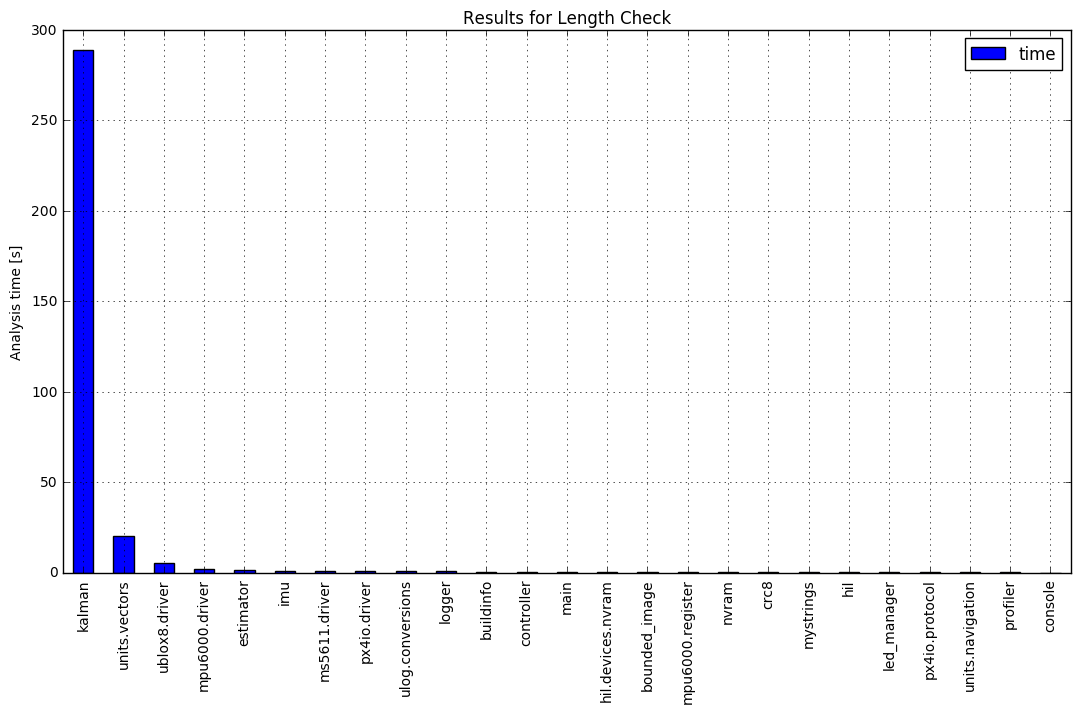

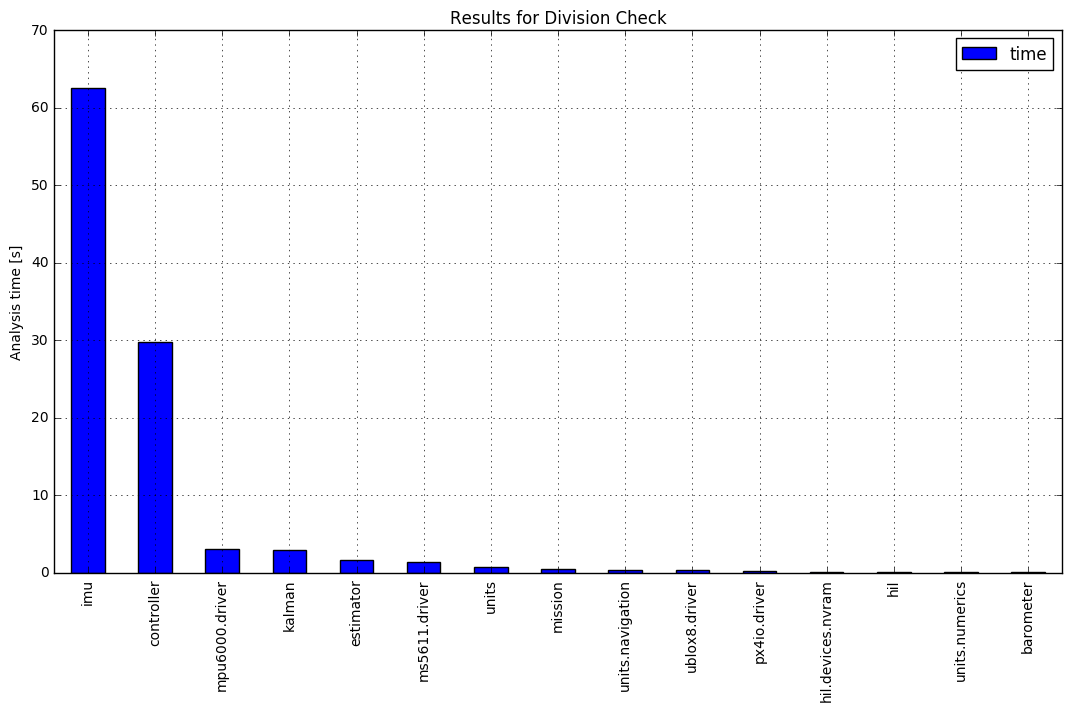

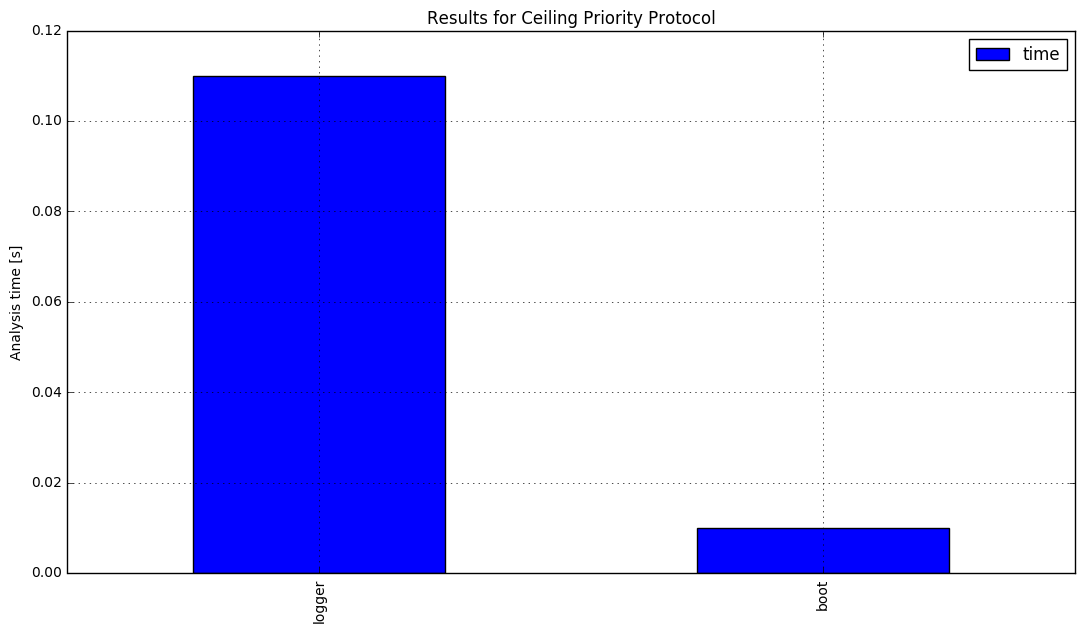

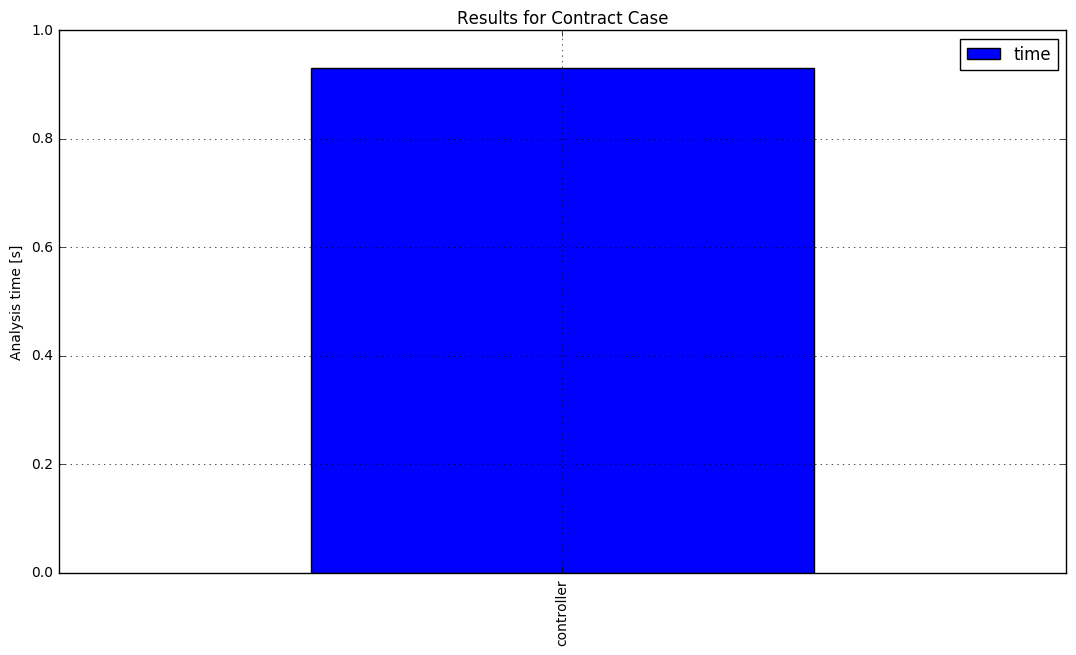

In [16]:
#print str(units['mission']['details_proofs'])
# 'check_tree' : [{'proof_attempts':{ <solver> : {'steps:..,'result':..,'time':..}}, 'transformations': {}}]

def parse_checktree(checktree):
    """
    decend into check_tree and return:
     - time sum of all proof attempts
     - count how often each solver was used
     - find most steps needed
    """
    ret = {'time': 0.0, 'solvers': {}, 'maxsteps': 0, 'result' : 'undefined'}
    howproved_counted = ['interval','flow']
    if not checktree:         
        return ret
    
    def strip_result(r):
        """
        Remove additional information from result and return a result class in {Valid, ...}
        """
        #print "REASON=" + str(r)                
        match = re.search(r'\w+ \(([^\)]+)\)', r)
        if match:            
            detail = match.group(1)
            if 'steps' in detail:
                return 'steplimit'
            elif 'time' in detail:
                return 'timeout'
            elif 'resource limit' in detail:
                return 'resourcelimit'
            else:
                return detail
        else:
            return r
    
    result = set()
    for chk in checktree:
            #print "chk=" + str(chk)
            if 'transformations' in chk and len (chk['transformations']) > 0:
                print "trafo; not handled: " + str(chk)
                return None
            if 'proof_attempts' in chk:
                for s,sd in chk['proof_attempts'].iteritems():
                    #print "attempt=" + str(s) + ":" + str(sd)
                    if not s in ret['solvers']: ret['solvers'][s] = {}
                    ret['solvers'][s]['cnt'] = ret['solvers'][s].get('cnt', 0) + 1
                    ret['time'] += sd['time']                    
                    if sd['steps'] > ret['maxsteps']: ret['maxsteps'] = sd['steps']
                    result.add(strip_result(sd['result']))                        
            else:
                print "no proof attempts"
            if 'how_proved' in chk and chk['how_proved'] in howproved_counted:
                ret['solvers'][chk['how_proved']] = ret['solvers'].get(chk['how_proved'], 0) + 1    
    
    # decide overall result of all provers    
    #print "result=" + str(result)
    if len(result) == 1:        
        ret["result"] = next(iter(result))        
    else:
        # multiple different reasons: if there is a timeout/stepout, then give this as reason; otherwise mention what is there        
        if any (substring in result for substring in ["timeout", "steplimit", "resourcelimit"]):
            reason = []
            if "steplimit" in result: reason.append("steplimit")
            if "resourcelimit" in result: reason.append("resourcelimit")
            if "timeout" in result: reason.append("timeout")
            ret["result"] = '|'.join(list(reason))
        else:            
            ret["result"] = '|'.join(list(result))
    #print "consolidated result:" + ret["result"]
    return ret

VCs = totals["rules"].keys()

####################
# summarize per VC
####################
res = {}
for u,ud in units.iteritems():
    res[u] =  { 'VC': { v : {'cnt':0, 'solvers': {}, 'time': 0.0, 'result': {}} for v in VCs }}
    t_total = 0.0
    maxsteps = 0
    if "details_proofs" in ud:        
        #print "num proofs in " + u + "=" + str(len(ud['details_proofs']))
        for p in ud['details_proofs']:
            vc = p['rule']
            res[u]['VC'][vc]['cnt'] += 1
            ct = parse_checktree(p['check_tree'])
            if ct:
                t_total += ct['time']
                res[u]['VC'][vc]['time'] += ct['time']                  
                if ct['maxsteps'] > maxsteps: maxsteps = ct['maxsteps']
                # merge dicts counting solver invocations
                for k,v in ct['solvers'].iteritems():
                    res[u]['VC'][vc]['solvers'][k] = res[u]['VC'][vc]['solvers'].get(k,0) + v['cnt']
                # we get no result class when there is no check tree. this happens for interval
                if ct['result'] == 'undefined':
                    if p['how_proved'] == 'interval':
                        ct['result'] = 'Valid' if p['severity'] == 'info' else 'interval failed'
                    else:
                        print "ERROR: unhandled value of how_proved. Not a solver, not interval check. what is it?"
                # we get back exactly one result class per check. Count how often this happens in the unit
                res[u]['VC'][vc]['result'][ct['result']] = res[u]['VC'][vc]['result'].get(ct['result'],0) + 1
    res[u]['time'] = t_total
    res[u]['result'] = {} # TODO: summarize 
    res[u]['maxsteps'] = maxsteps

print "################################"
print "# TOTAL CPU TIME = {0:0.1f} min".format(sum([ud['time'] for u,ud in res.iteritems()])/60)
print "################################"
print "Note: divide by number of cores to get approximate wall-clock time"
    
#print " "
#print "Mission:"
#print res['mission']
            

def plot_vcstats(vcname):
    """
    Make a plot showing time spent in a specific VC for all modules
    """
    pdata = {}
    for u,ud in res.iteritems():
        if vcname in ud['VC']:
            t = ud['VC'][vcname]['time']
            if t > 0.0: pdata[u] = t                

    if len(pdata.keys()) == 0: return
                
    df_vc = pd.DataFrame(pdata, index=['time']).T
    df_vc.sort_values(by=['time'], inplace=True, ascending=False)
    ax=df_vc.plot.bar(figsize=(13,7));
    ax.set_ylabel('Analysis time [s]')
    ax.set_title('Results for ' + pretty_vcname(vcname))
    ax.grid()
    plt.savefig(FOLDER + os.sep + 'time_in_' + vcname + '.pdf', bbox_inches='tight')    
    plt.show()    
    
###########################
# plot total time per unit
###########################
df_unittime = pd.DataFrame({k:v['time'] for k,v in res.iteritems() if v['time'] > 0.0}, index=['time']).T
df_unittime.sort_values(by=['time'], inplace=True, ascending=False)
ax=df_unittime.plot.bar(figsize=(15,5))
ax.set_ylabel('analysis time [s]')
ax.set_title('Analysis time vs. Unit')
ax.grid()
plt.savefig(FOLDER + os.sep + 'units_time.pdf', bbox_inches='tight')
plt.show()
    
###########################
# plot maxsteps per unit
###########################
df_unitsteps = pd.DataFrame({k:v['maxsteps'] for k,v in res.iteritems() if v['maxsteps'] > 0}, index=['steps']).T
df_unitsteps.sort_values(by=['steps'], inplace=True, ascending=False)
ax=df_unitsteps.plot.bar(figsize=(15,5))
ax.set_ylabel('steps')
ax.set_title('Analysis steps vs. Unit')
ax.grid()
plt.savefig(FOLDER + os.sep + 'steps.pdf', bbox_inches='tight')
plt.show()
    
########################
# plot VC time per unit
########################

for vc in totals["rules"].keys():    
    plot_vcstats(vc)

# How often do we fail because of timeout/stepout?

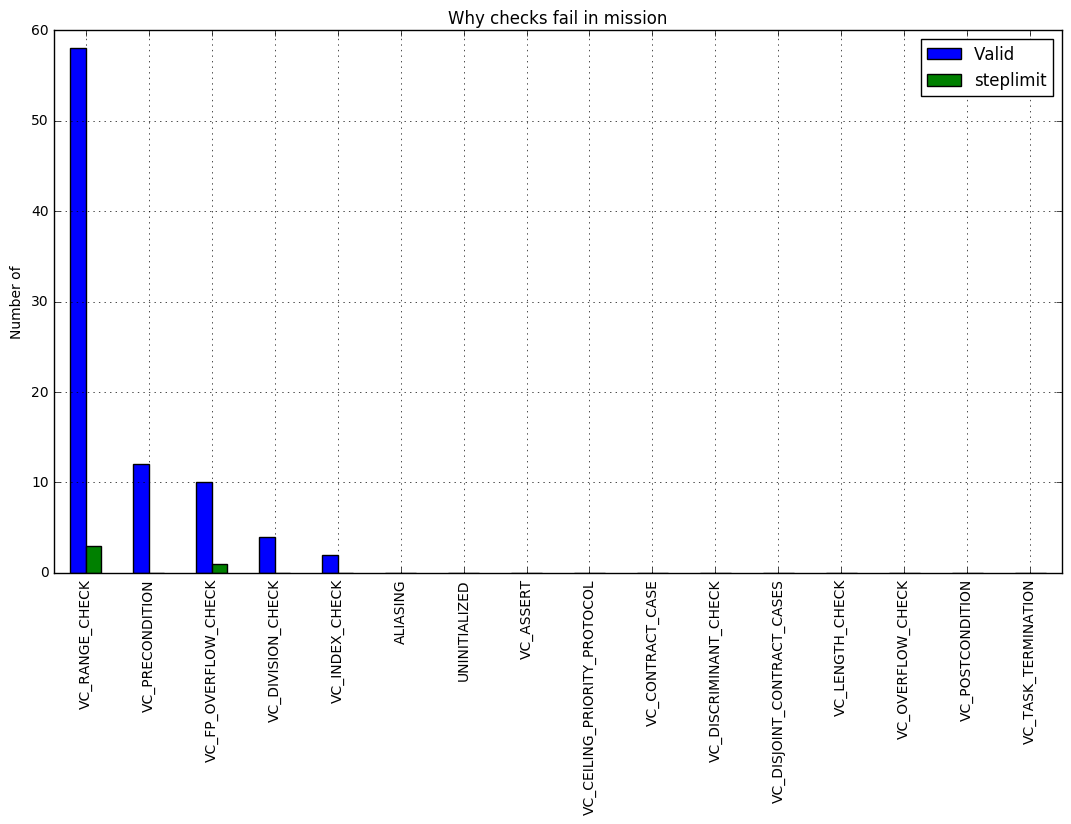

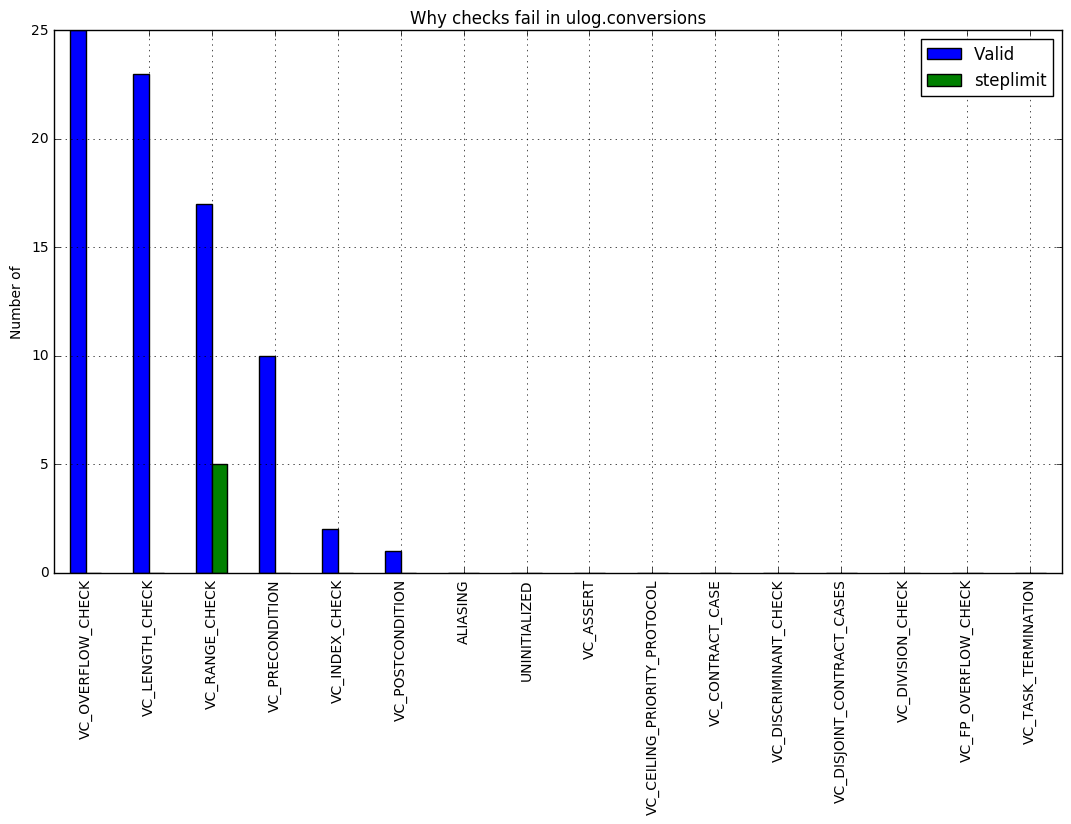

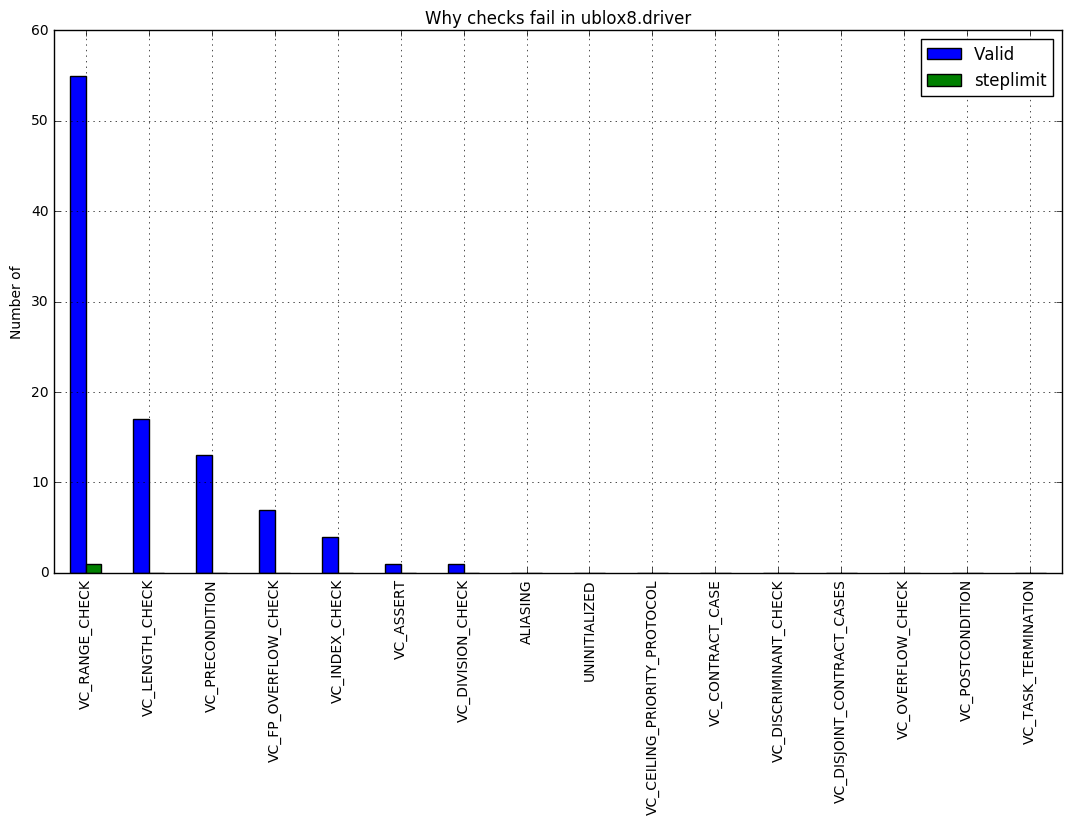

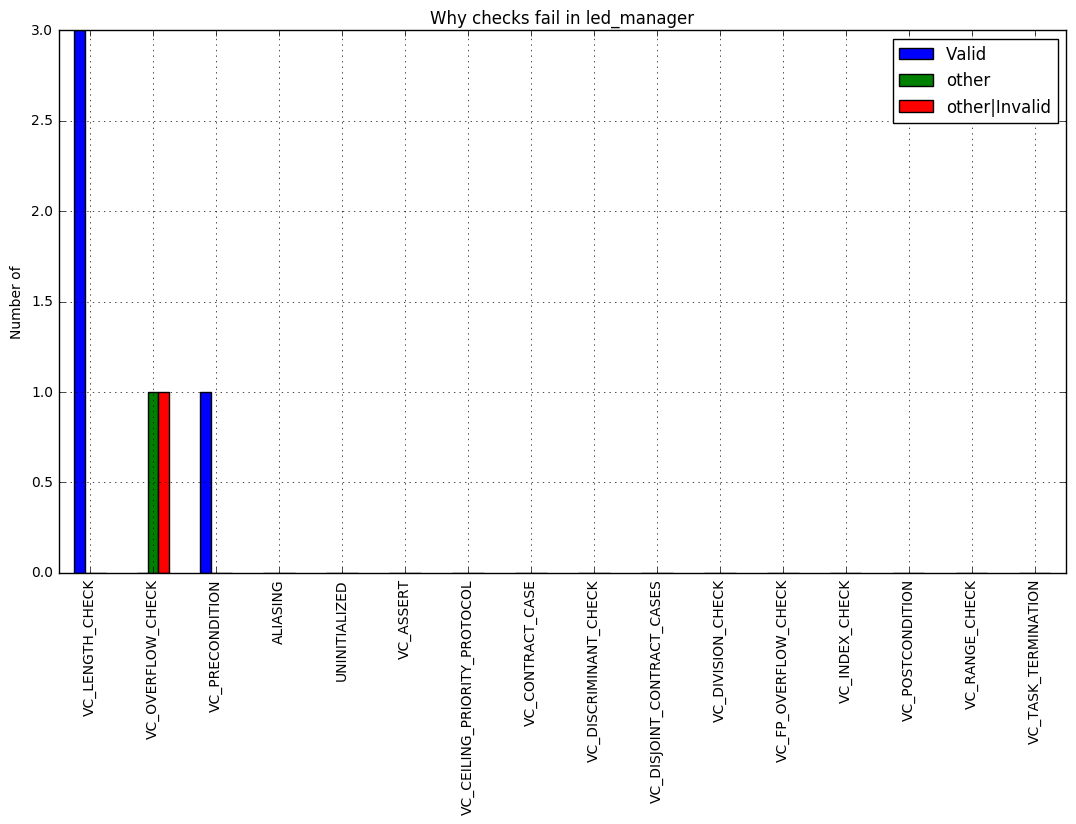

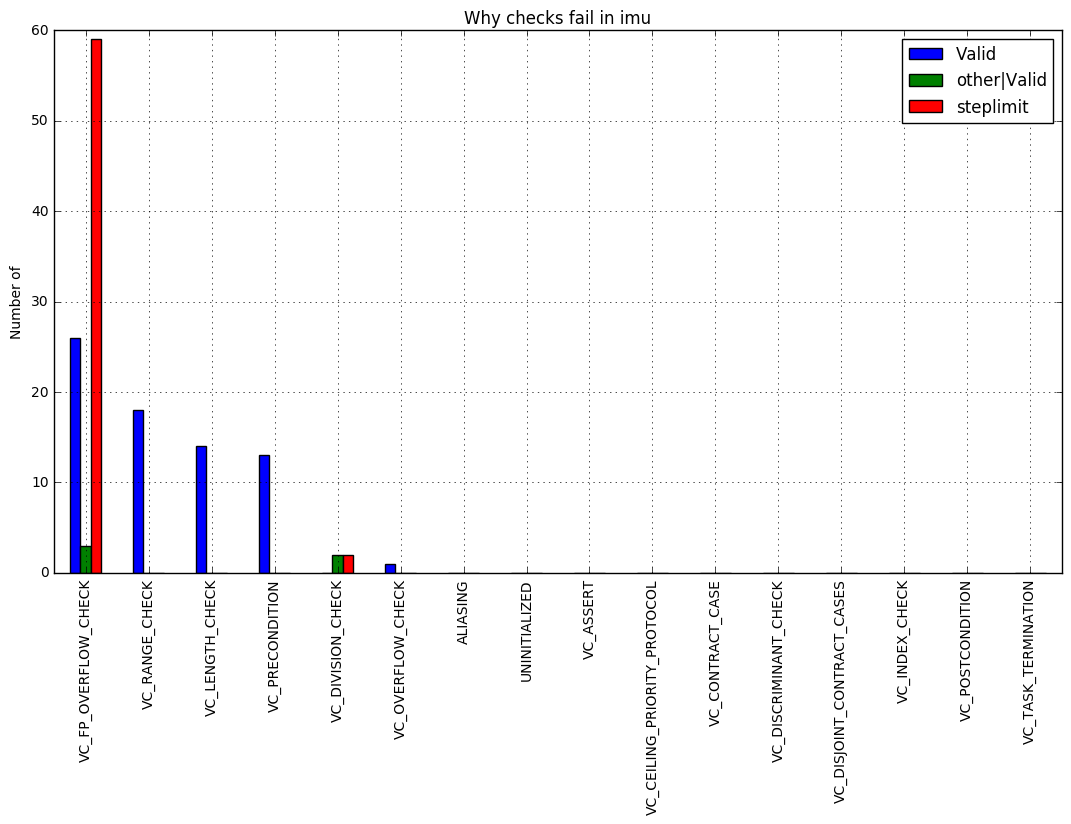

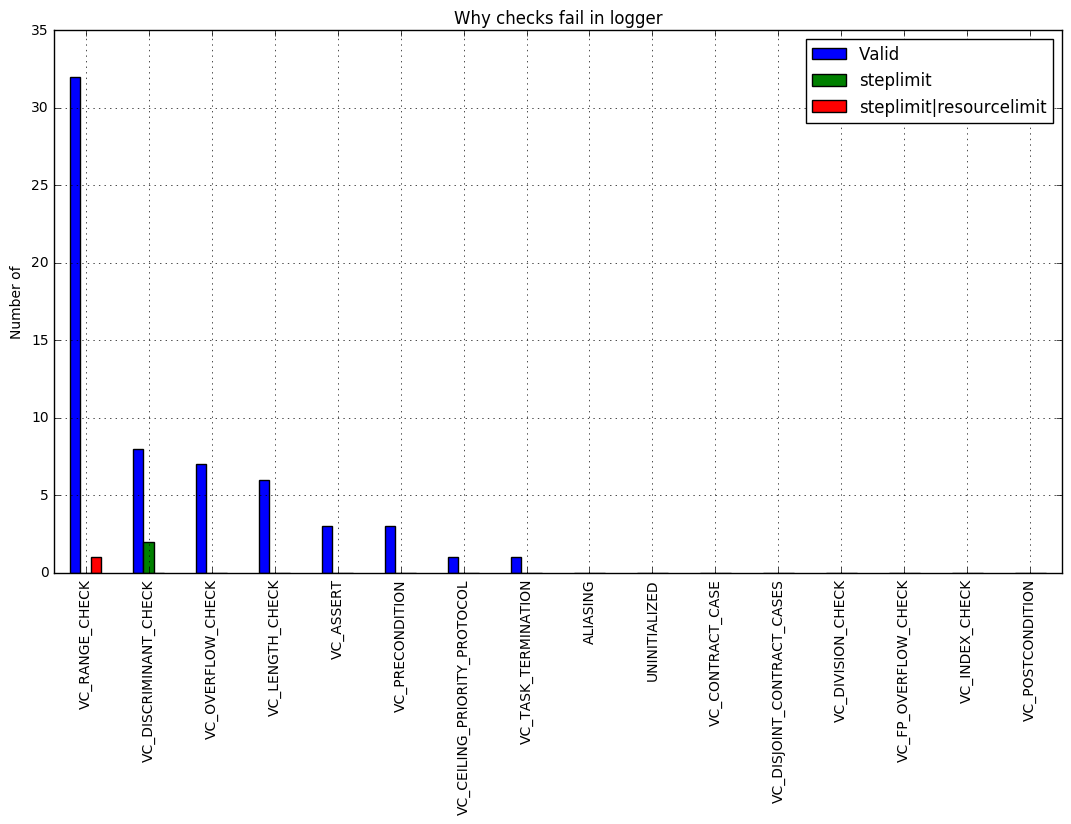

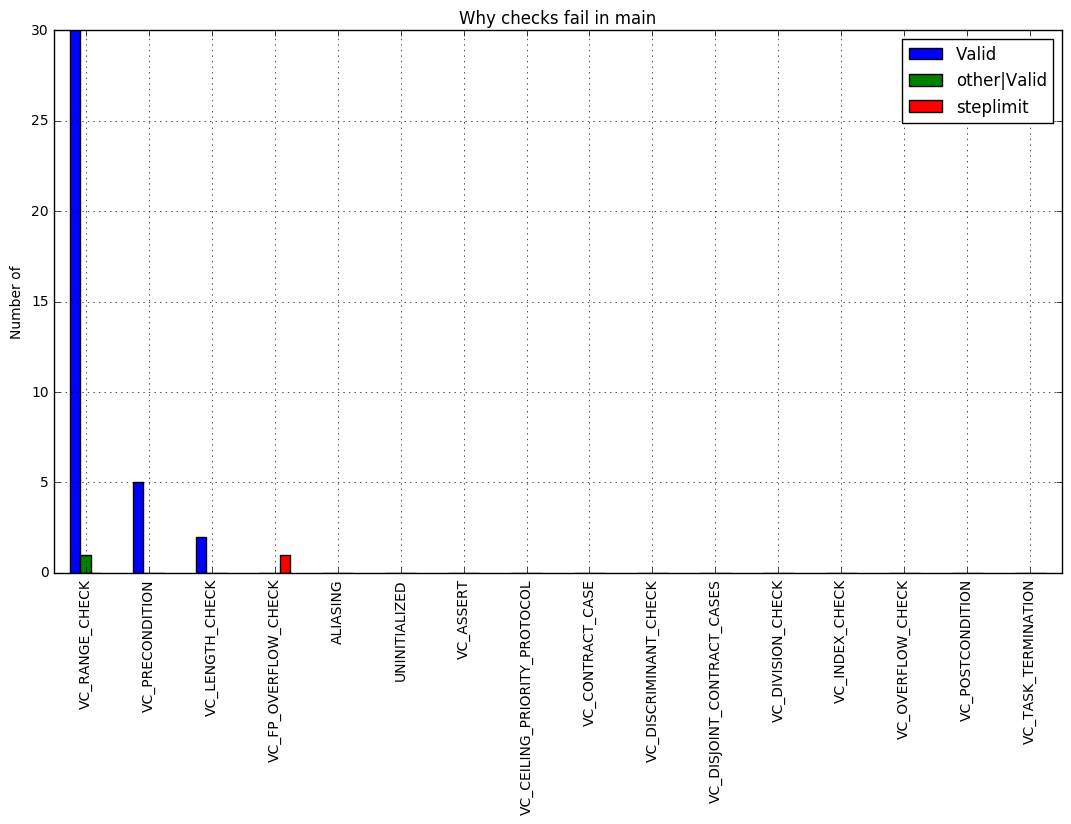

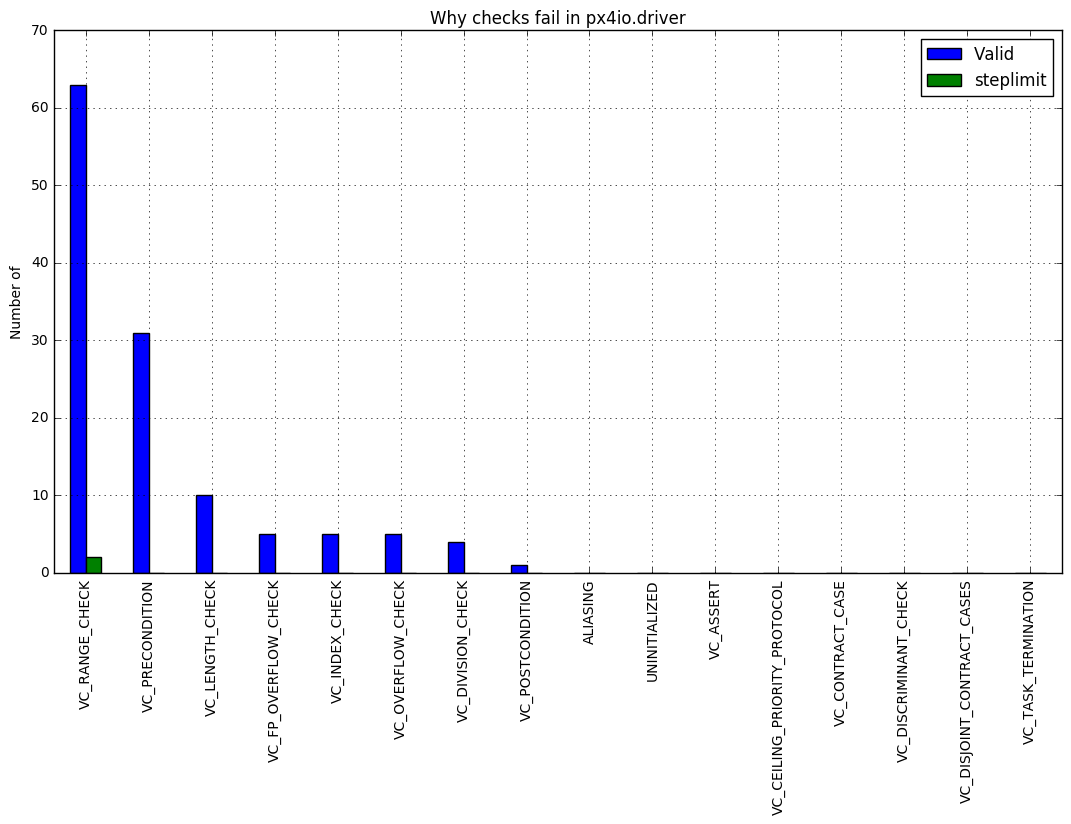

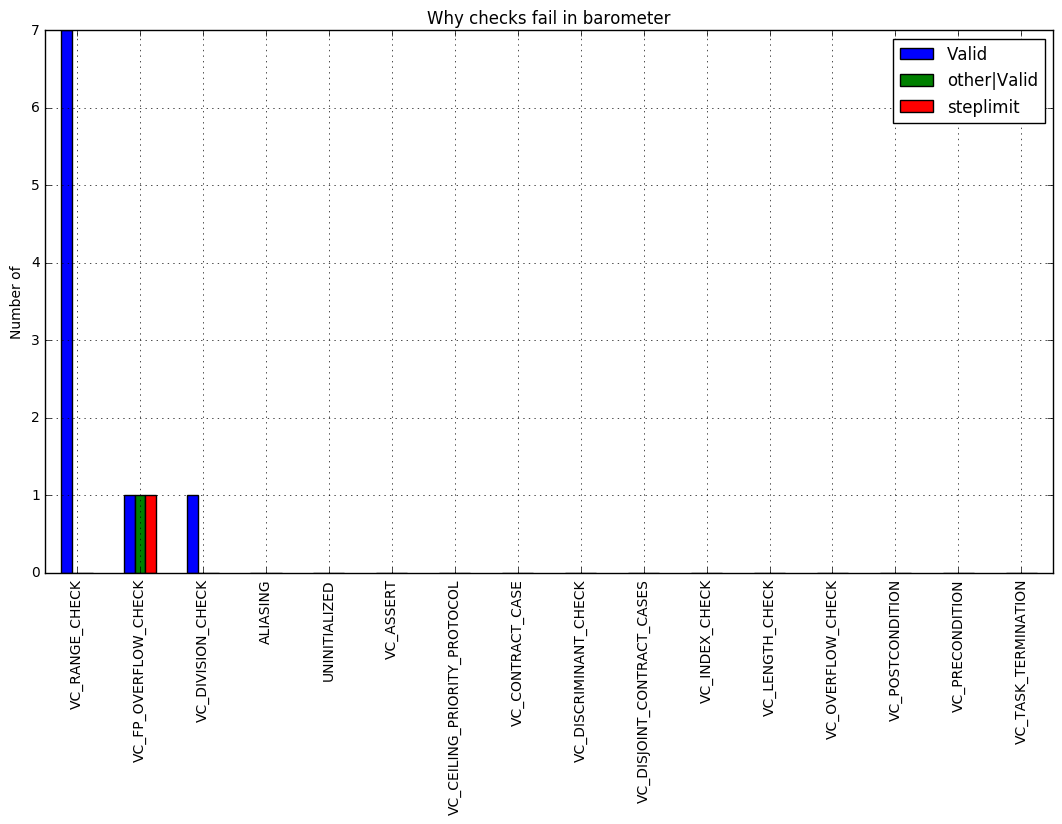

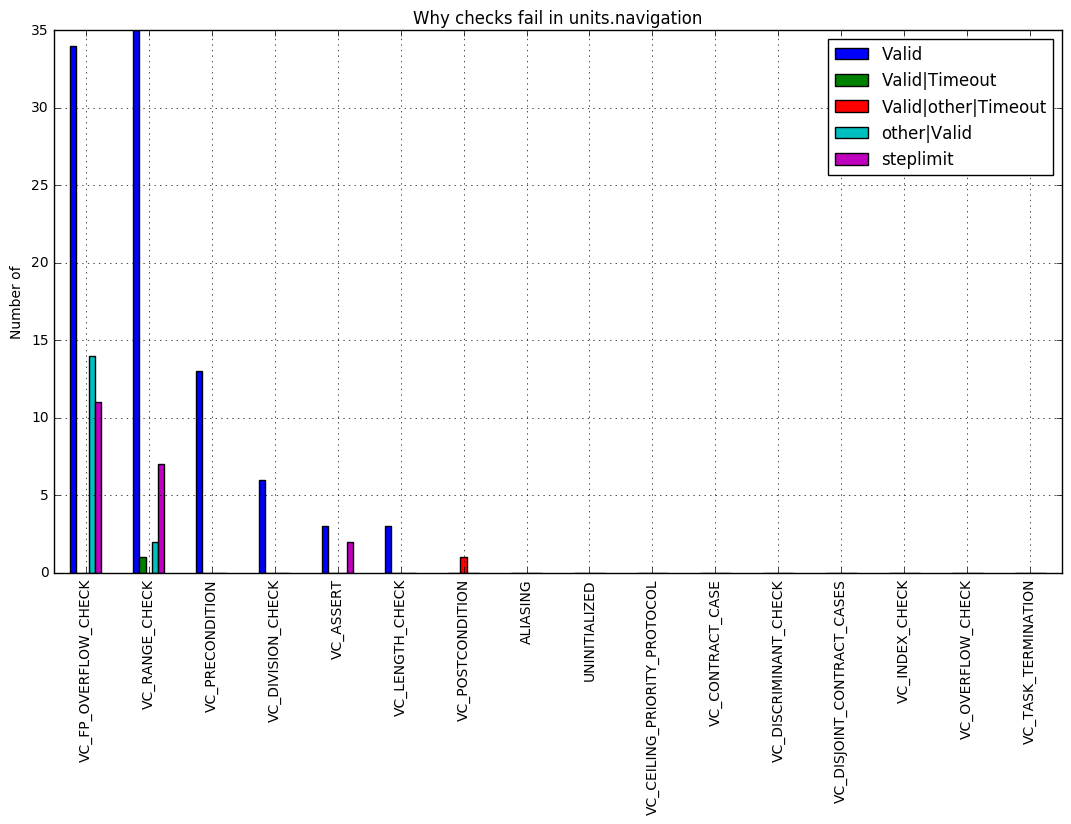

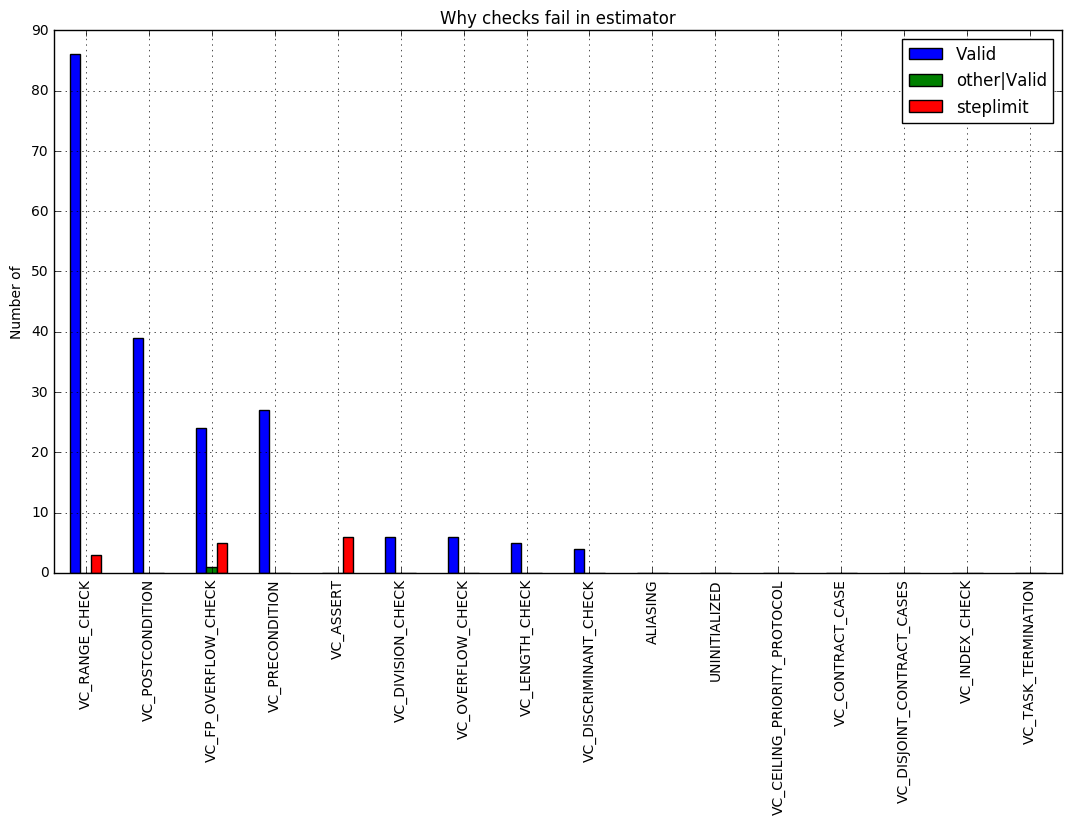

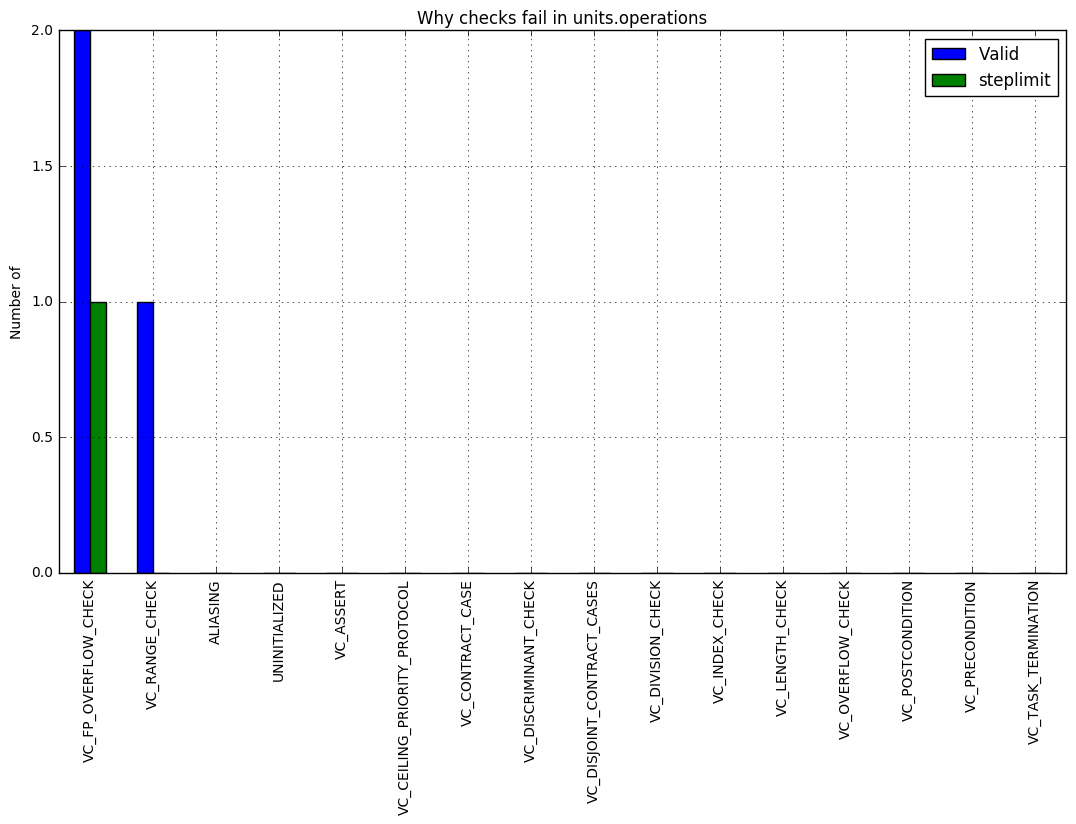

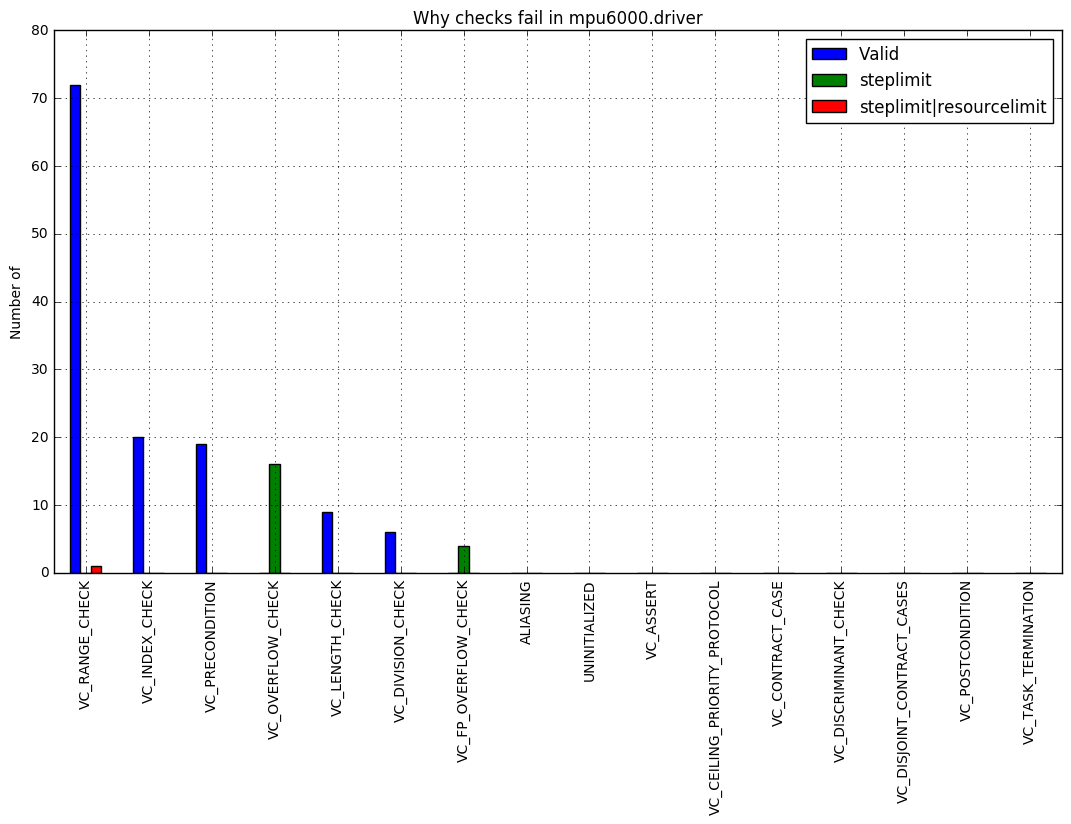

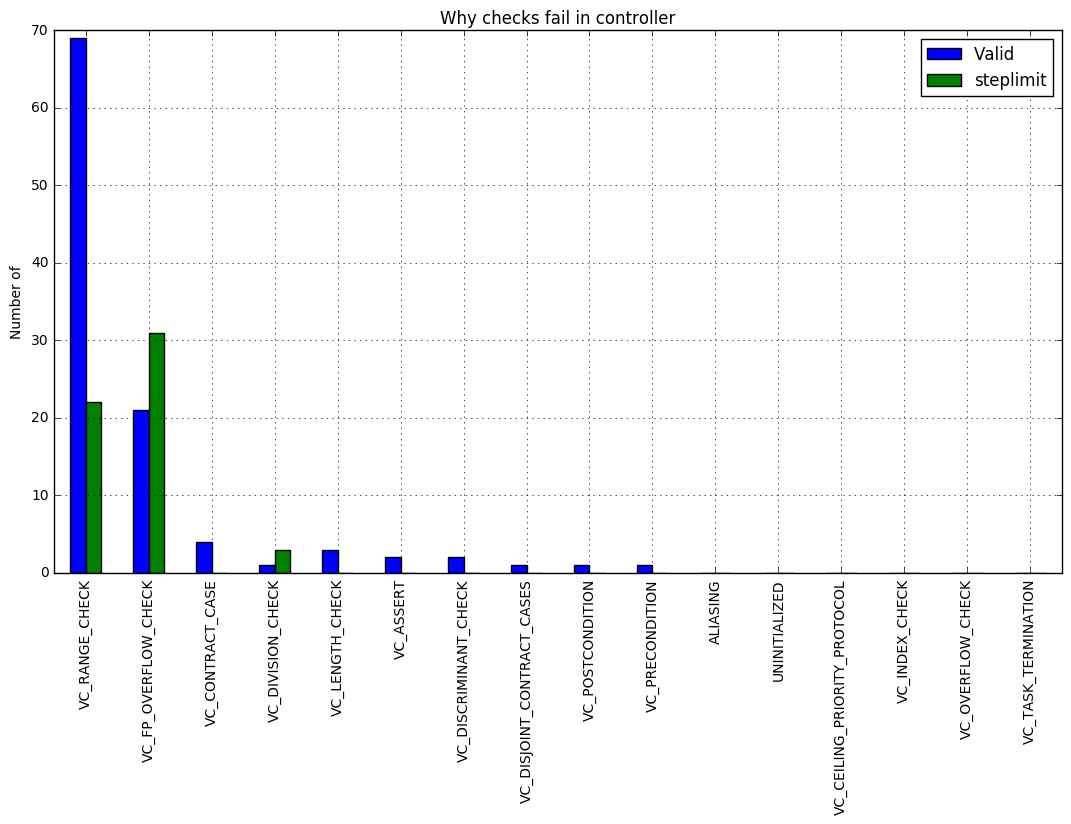

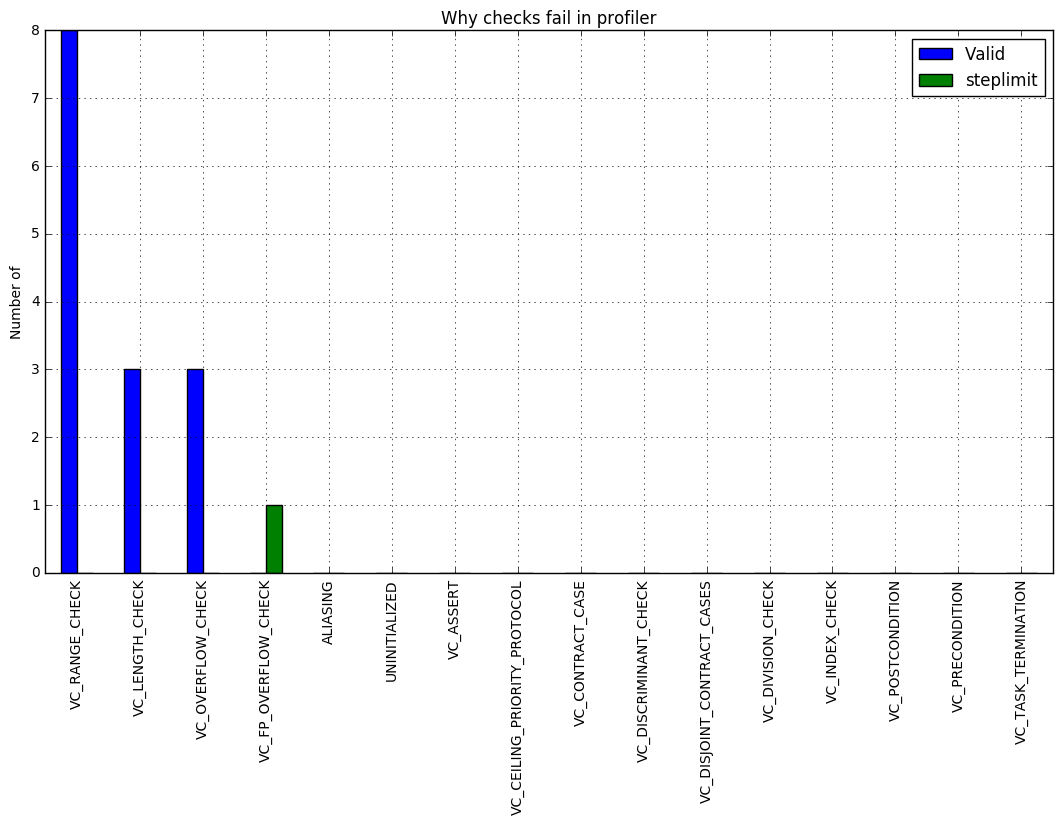

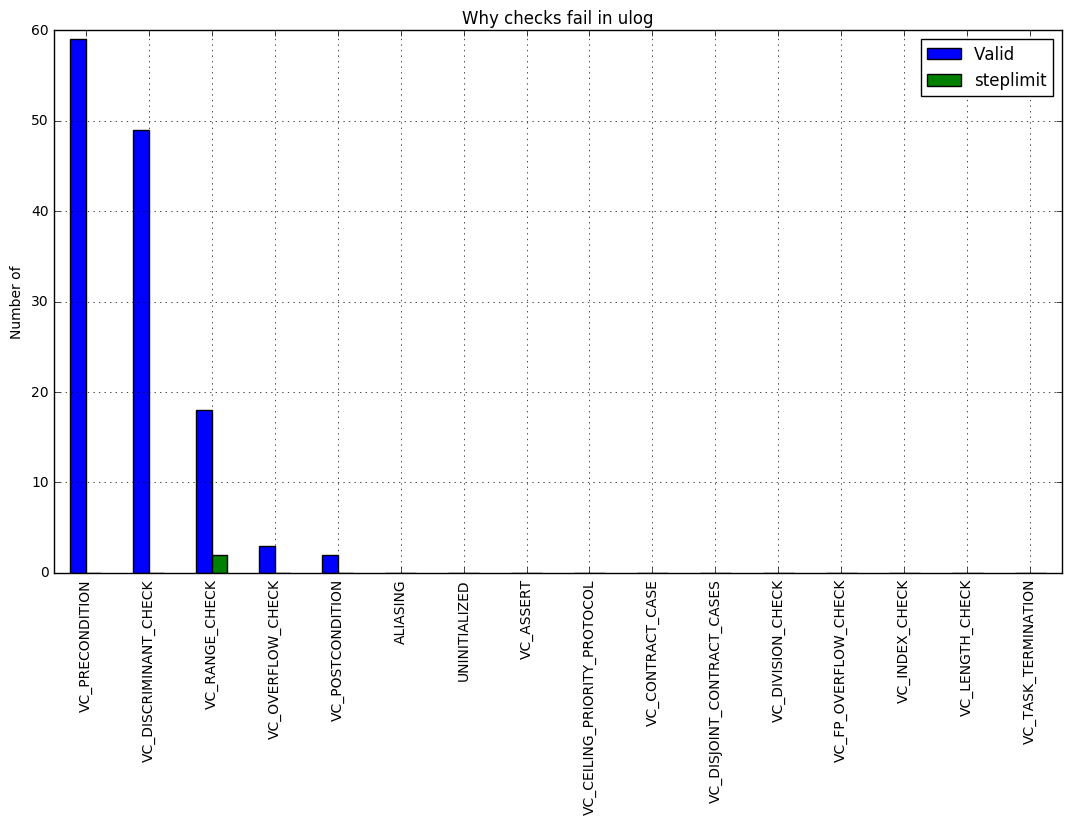

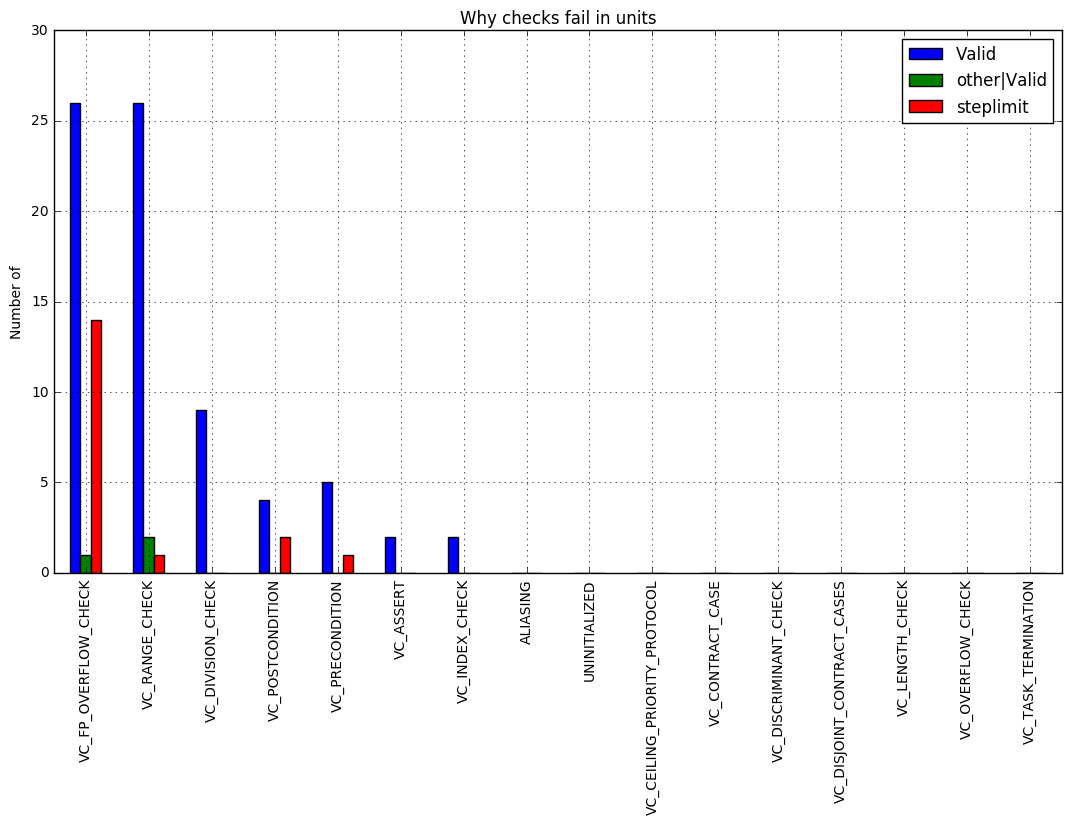

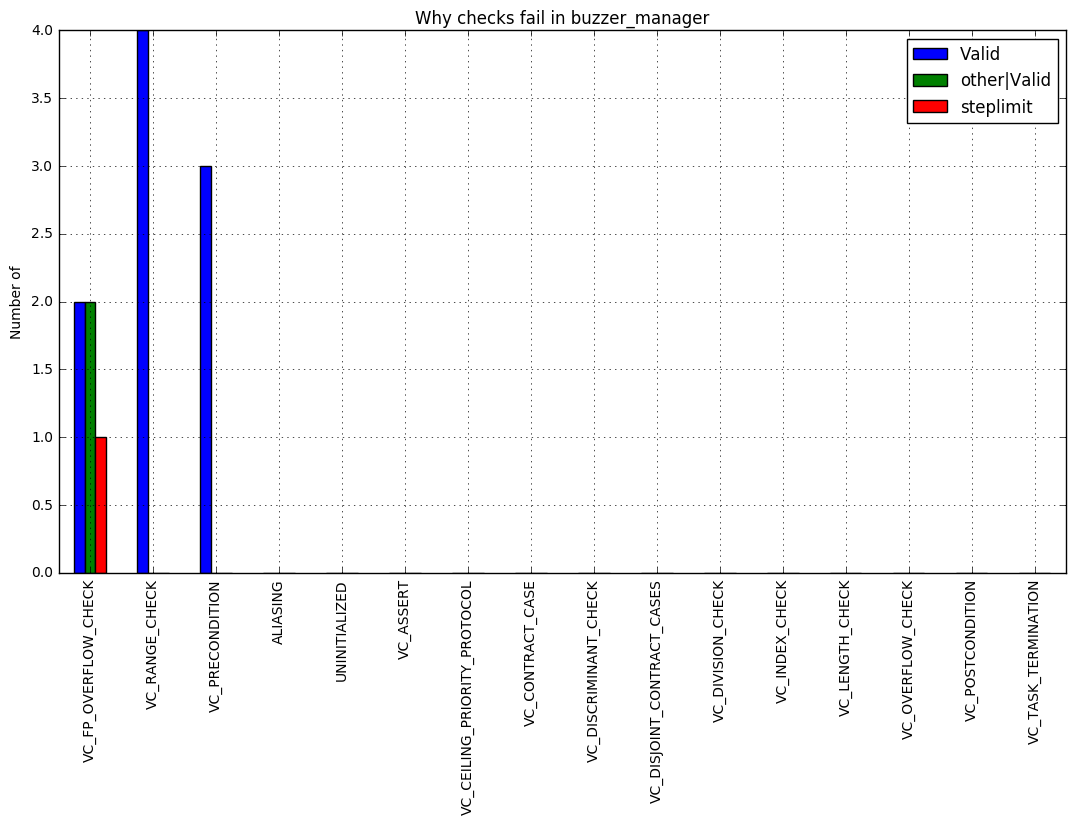

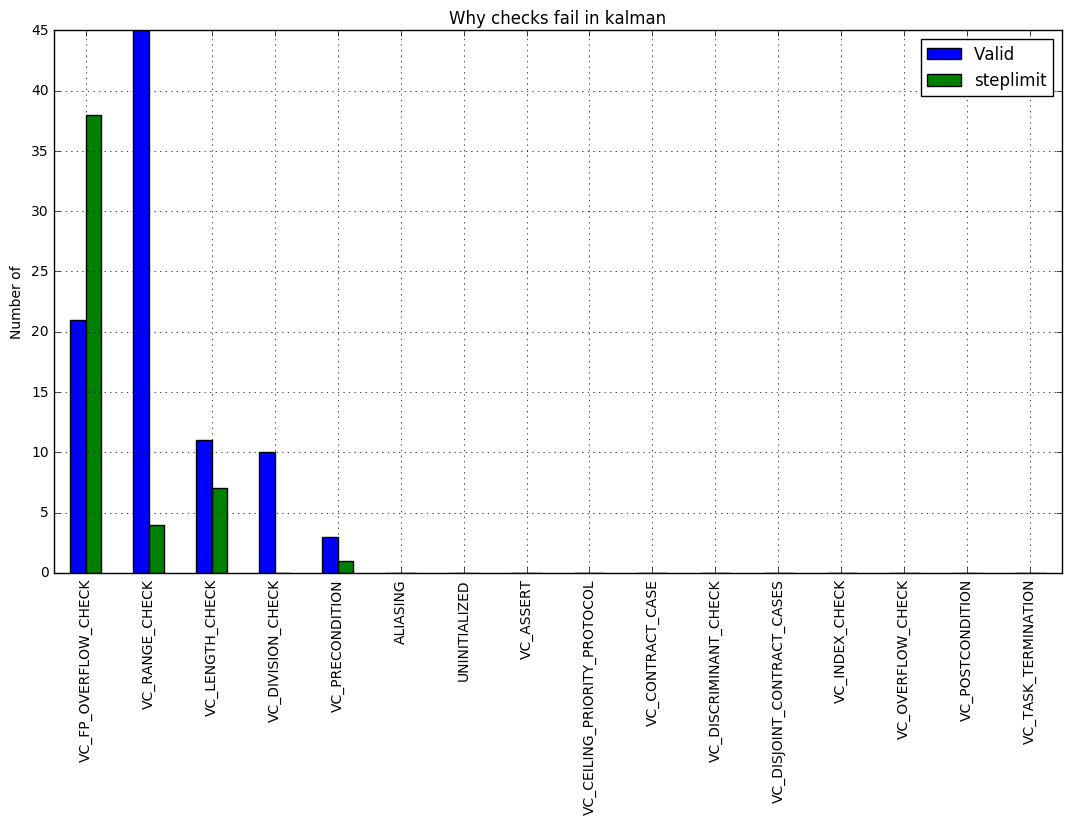

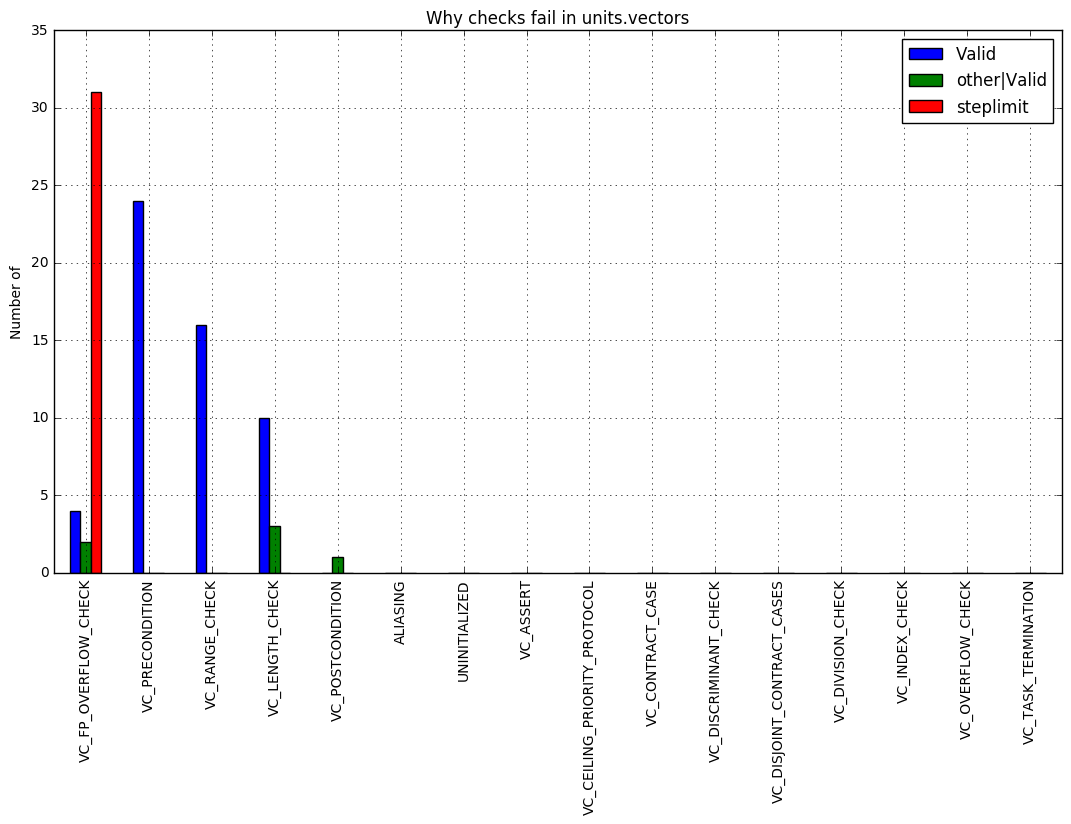

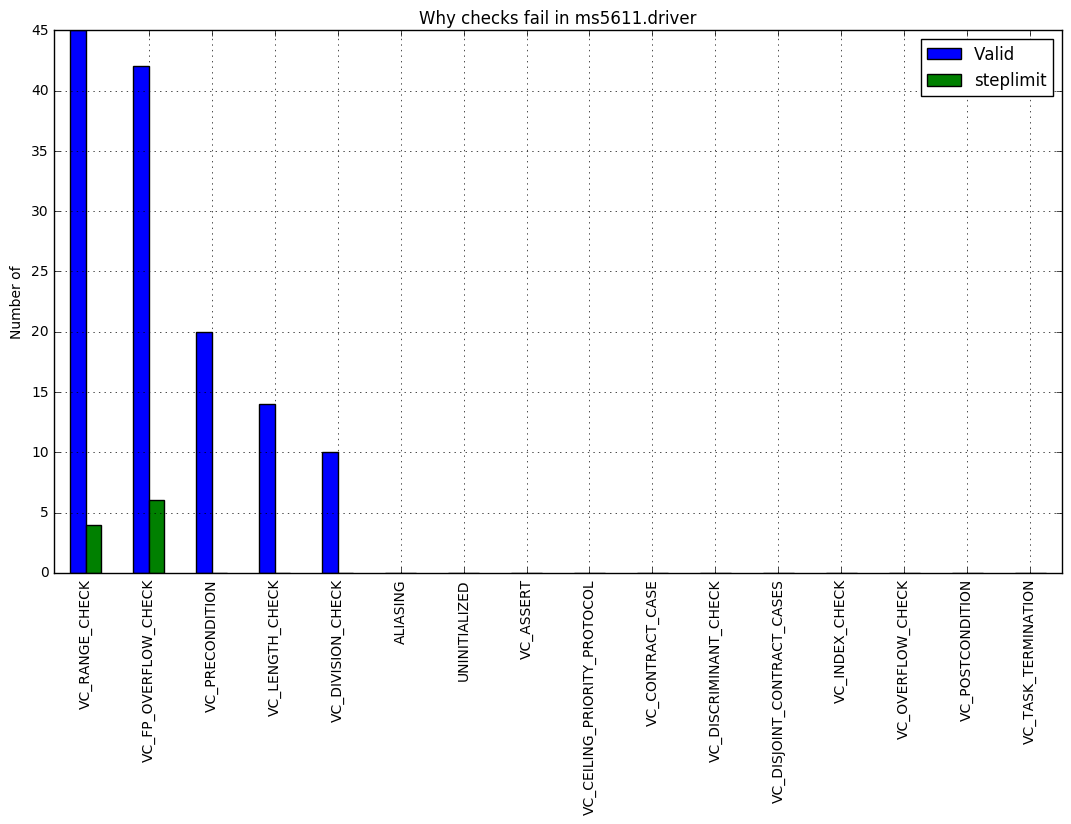

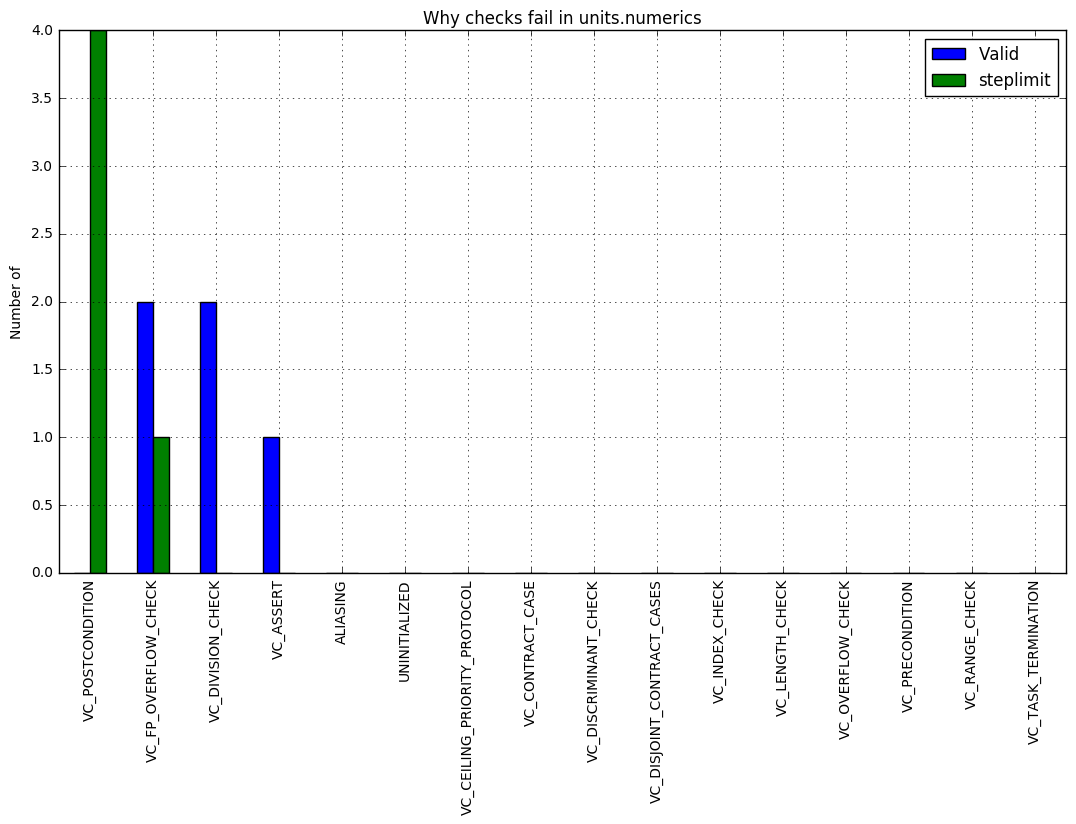

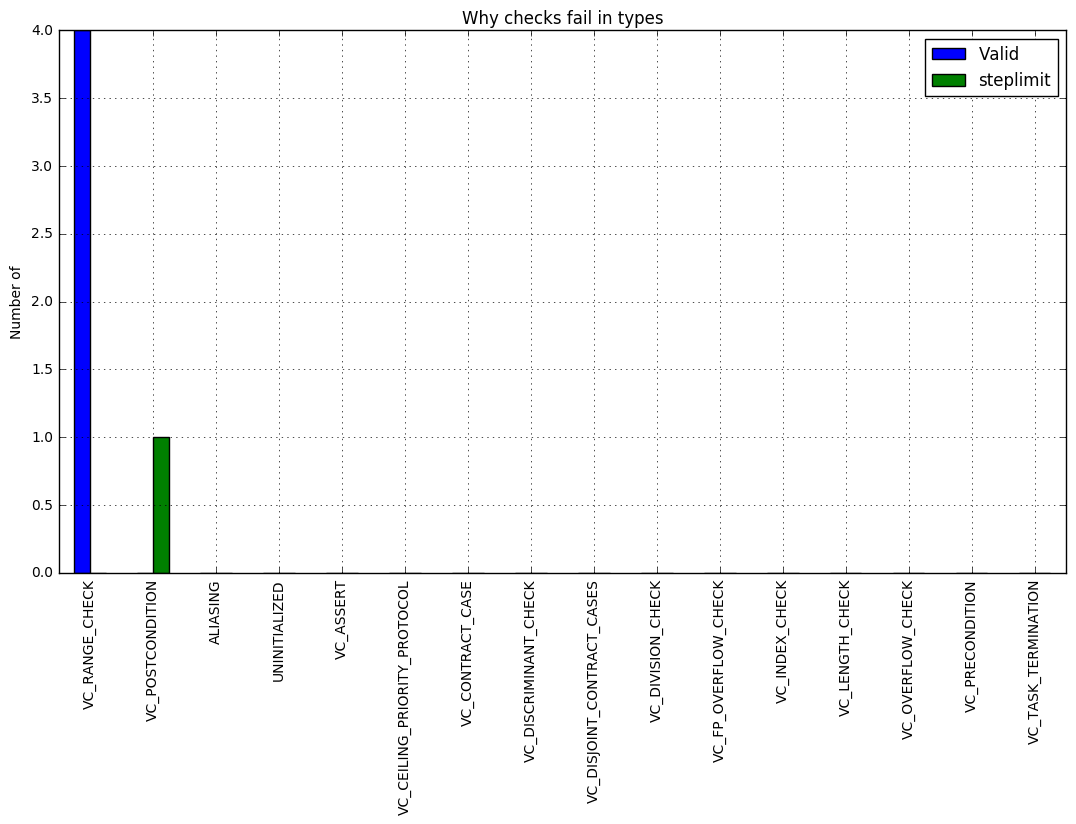

In [17]:
#print " "
#print "Mission:"
#print res['mission']
#  u'VC_RANGE_CHECK': {'cnt': 61, 'time': 68.78999999999995, 'result': {'steplimit': 3, u'Valid': 48, 'undefined': 10}, 'solvers': {u'CVC4': 51, u'altergo': 3, u'CVC4_CE': 3, u'Z3': 3}}

def plot_failure_reason(unit):
    """
    Make a plot showing why checks in unit fail
    """            
    pdata = {v : vd['result'] for v,vd in res[unit]['VC'].iteritems()}# if vd and 'cnt' in vd and vd['cnt'] > 0}
    
    # add 'cnt' to each VC (total)
    for v,vd in pdata.iteritems():        
        vd['cnt'] = res[unit]['VC'][v]['cnt']        
    
    if len(pdata.keys()) == 0: 
        print "no data for " + unit
        return
          
    df_vc = pd.DataFrame(pdata).T
    df_vc.sort_values(by=['cnt'], inplace=True, ascending=False)
    
    exclude_columns=['cnt']
    ax=df_vc.ix[:,df_vc.columns.difference(exclude_columns)].plot.bar(figsize=(13,7));
    ax.set_ylabel('Number of')
    ax.set_title('Why checks fail in ' + unit)
    ax.grid()
    plt.savefig(FOLDER + os.sep + 'unit_fails_' + unit + '.pdf', bbox_inches='tight')    
    plt.show() 
    
for k in units.keys():
    if units[k]["success"] < 100.0: plot_failure_reason (k)